In [13]:
import music21
import os
import numpy as np
import pandas as pd
from music21 import converter, instrument, note, chord, tempo
import pickle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Conv1D, Dense, GlobalAveragePooling1D, Input, Add, Softmax
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Lambda,RepeatVector,TimeDistributed,Layer,Embedding, Dense, LayerNormalization, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, LSTM, Dense, Lambda, RepeatVector, TimeDistributed
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from mido import MidiFile
import fractions
from tensorflow.keras.optimizers import RMSprop




In [14]:
#trích xuất thông tin từ file MIDI, bao gồm nốt nhạc, nhạc cụ, thời gian và lưu vào CSV.
def read_midi_with_music21(file_path): # hàm nhận vào đường dẫn của file mid và trích xuất thông tin về các nốt nhạc và nhạc cụ.
    #Trả về một danh sách chứa thông tin về các nốt nhạc có trong file mid
    """
    Đọc và trích xuất thông tin từ file MIDI sử dụng music21.
    
    Args:
        file_path (str): Đường dẫn file MIDI.
    
    Returns:
        list: Danh sách chứa thông tin về nhạc cụ và nốt nhạc trong bài hát.
    """
    try:
        # Load file MIDI
        midi_data = music21.converter.parse(file_path)
        
        song_data = []
        
        # Duyệt qua tất cả các nhạc cụ trong file MIDI
        for part in midi_data.parts: # lấy tất cả các phần nhạc cụ có trong bản mid
            instrument = part.getInstrument()   # lấy thông tin về nhạc cụ của phần nhạc đó
            instrument_name = str(instrument)
            # Lấy thông tin các nốt nhạc trong phần nhạc cụ
            for note in part.flatten().notes:  # Thay .flat bằng .flatten()
                if isinstance(note, music21.note.Note):  # Nếu là nốt nhạc
                    song_data.append({
                        "file_name": os.path.basename(file_path),# tên file mid
                        "note_type": "Note",
                        "pitch": note.name,# cao độ của nốt 
                        "duration": note.quarterLength,# độ dài nốt
                        "start_time": note.offset,#time nốt bắt đầu trong bài hát 
                    })
                elif isinstance(note, music21.note.Rest):  # Nếu là nghỉ
                    song_data.append({
                        "file_name": os.path.basename(file_path),
                        "instrument": instrument_name,
                        "note_type": "Rest",
                        "pitch": "Rest", 
                        "duration": note.quarterLength,
                        "start_time": note.offset,
                    })
        
        return song_data
    
    except Exception as e:
        print(f"Lỗi khi đọc file MIDI: {e}")
        return None

def segment_midi_data(midi_data, segment_length=20.0):
    """
    Chia dữ liệu MIDI thành các đoạn nhỏ theo thời gian.

    Args:
        midi_data (list): Dữ liệu MIDI đã trích xuất.
        segment_length (float): Độ dài mỗi đoạn (giây).
    
    Returns:
        list: Danh sách các đoạn đã phân chia.
    """
    if not midi_data:
        return []
    
    max_time = max(note["start_time"] for note in midi_data)
    segments = []
    start_time = 0.0
    
    while start_time < max_time:
        end_time = start_time + segment_length
        segment = [note for note in midi_data if start_time <= note["start_time"] < end_time]
        
        if segment:
            segments.append(segment)
        
        start_time += segment_length
    
    return segments

# Đường dẫn tới thư mục chứa các file MIDI
midi_files_directory = "D:/CĐE/data"

# Lấy danh sách tất cả các file .mid trong thư mục
midi_files = [os.path.join(midi_files_directory, f) for f in os.listdir(midi_files_directory) if f.endswith('.mid')]

# Giới hạn số file đọc (ví dụ: 45 file)
midi_files = midi_files[:45]

all_segmented_data = []

# Xử lý từng file
for file in midi_files:
    song_data = read_midi_with_music21(file)
    if song_data:
        segments = segment_midi_data(song_data, segment_length=20.0)
        for i, segment in enumerate(segments):
            for note in segment:
                note["segment"] = i  # Thêm số thứ tự đoạn
            all_segmented_data.extend(segment)

# Lưu kết quả vào file CSV nếu có dữ liệu
if all_segmented_data:
    df = pd.DataFrame(all_segmented_data)
    output_file = "D:/CĐE/test/midi_segmented.csv"
    df.to_csv(output_file, index=False)
    print(f"Dữ liệu đã được lưu vào: {output_file}")
else:
    print("Không có dữ liệu nào được trích xuất.")

Dữ liệu đã được lưu vào: D:/CĐE/test/midi_segmented.csv


In [15]:
df = pd.read_csv('D:/CĐE/test/midi_segmented.csv')
df.sample(n=15, random_state=42)  

,file_name,note_type,pitch,duration,start_time,segment
17245,Để Gió Cuốn Đi.mid,Note,F,3.0,18.0,0
1355,Bay Đi Thầm Lăng.mid,Note,E,0.75,1112.5,55
2319,Ben Doi Hiu Quanh.mid,Note,A,1.0,38.0,1
19,Bay Đi Thầm Lăng.mid,Note,F,1.5,13.5,0
6434,Doa Hoa Vo Thuong.mid,Note,F#,0.25,320.75,14
13103,NỐI VÒNG TAY LỚN.mid,Note,D,0.5,309.0,15
15057,TUOI DA BUON.mid,Note,D,0.5,363.0,18
4614,Cho một người nằm xuống.mid,Note,D,1/3,85.5,4
11523,Nhớ mùa thu Hà Nội.mid,Note,B,0.5,77.5,3
5170,Cát bụi.mid,Note,C,0.25,63.5,3


In [16]:
import os
import pickle
from music21 import converter, note, chord, stream

def midi_to_matrix(midi_file):
    """ Đọc file MIDI và chuyển đổi nó thành một ma trận dạng piano roll """
    try:
        # Đọc file MIDI
        midi_data = converter.parse(midi_file)
        
        # Kiểm tra xem file MIDI có đúng là một bản nhạc không
        if not isinstance(midi_data, stream.Score):
            print(f"Lỗi: {midi_file} không phải là một đối tượng music21 Score")
            return None

        # Lấy danh sách các nốt nhạc và hợp âm
        piano_roll = midi_data.flat.notes
        matrix = []

        for element in piano_roll:
            if isinstance(element, note.Note):  # Nếu là nốt nhạc đơn
                matrix.append({
                    "pitch": element.nameWithOctave,  # Cao độ của nốt
                    "duration": element.quarterLength,  # Độ dài nốt (theo đơn vị nốt đen)
                    "offset": element.offset,  # Vị trí bắt đầu của nốt nhạc
                    "velocity": element.volume.velocity if element.volume else None  # Cường độ (nếu có)
                })
            elif isinstance(element, chord.Chord):  # Nếu là hợp âm
                for pitch in element.pitches:
                    matrix.append({
                        "pitch": pitch.nameWithOctave,  
                        "duration": element.quarterLength,  
                        "offset": element.offset,  
                        "velocity": element.volume.velocity if element.volume else None
                    })
        
        return matrix
    except Exception as e:
        print(f"Lỗi khi đọc file MIDI {midi_file}: {e}")
        return None

# Đường dẫn tới thư mục chứa các file MIDI
midi_files_directory = r"D:\CĐE\data"  # Thêm 'r' để tránh lỗi escape sequence

# Kiểm tra thư mục có tồn tại không
if not os.path.exists(midi_files_directory):
    raise FileNotFoundError(f"Thư mục {midi_files_directory} không tồn tại!")

# Lấy danh sách file MIDI
midi_files = [os.path.join(midi_files_directory, f) for f in os.listdir(midi_files_directory) if f.endswith('.mid')]

# Giới hạn số lượng file đọc là 41
midi_files = midi_files[:41]

# Xử lý và lưu dữ liệu
processed_data = []

for file in midi_files:
    print(f"Processing: {file}")
    matrix = midi_to_matrix(file)
    if matrix:
        processed_data.append(matrix)

# Lưu dữ liệu đã xử lý vào file pickle
output_file = r"D:\CĐE\test\midi_data_music21.pkl"
with open(output_file, "wb") as f:
    pickle.dump(processed_data, f)

print(f"Lưu dữ liệu hoàn tất! File lưu tại {output_file}")


Processing: D:\CĐE\data\Bay Đi Thầm Lăng.mid

d:\CĐE\myenv\Lib\site-packages\music21\stream\base.py:3689: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


Processing: D:\CĐE\data\Ben Doi Hiu Quanh.mid
Processing: D:\CĐE\data\Biển nhớ.mid
Processing: D:\CĐE\data\Ca Dao Mẹ.mid
Processing: D:\CĐE\data\Chiếc lá tu pai.mid
Processing: D:\CĐE\data\Cho một người nằm xuống.mid
Processing: D:\CĐE\data\Cho Đời Chút Ơn.mid
Processing: D:\CĐE\data\Co Xot Xa Dua.mid
Processing: D:\CĐE\data\Cuối Cùng Cho Một Tình Yêu.mid
Processing: D:\CĐE\data\Cát bụi.mid
Processing: D:\CĐE\data\CÒN TUỔI NÀO CHO EM.mid
Processing: D:\CĐE\data\Có một dòng sông đã qua đời..mid
Processing: D:\CĐE\data\Diễm xưa.mid
Processing: D:\CĐE\data\Doa Hoa Vo Thuong.mid
Processing: D:\CĐE\data\Em Còn Nhớ Hay Em Đã Quên.mid
Processing: D:\CĐE\data\Em Hãy Ngủ Đi.mid
Processing: D:\CĐE\data\Gia tài của Mẹ.mid
Processing: D:\CĐE\data\Goi Ten Bon Mua.mid
Processing: D:\CĐE\data\Hay yeu nhau di.mid
Processing: D:\CĐE\data\Hoa vàng mấy độ..mid
Processing: D:\CĐE\data\Hue Sai Gon Ha Noi.mid
Processing: D:\CĐE\data\Huyền Thoại Mẹ.mid
Processing: D:\CĐE\data\HÀ NỘI 12 MÙA HOA.mid
Processing

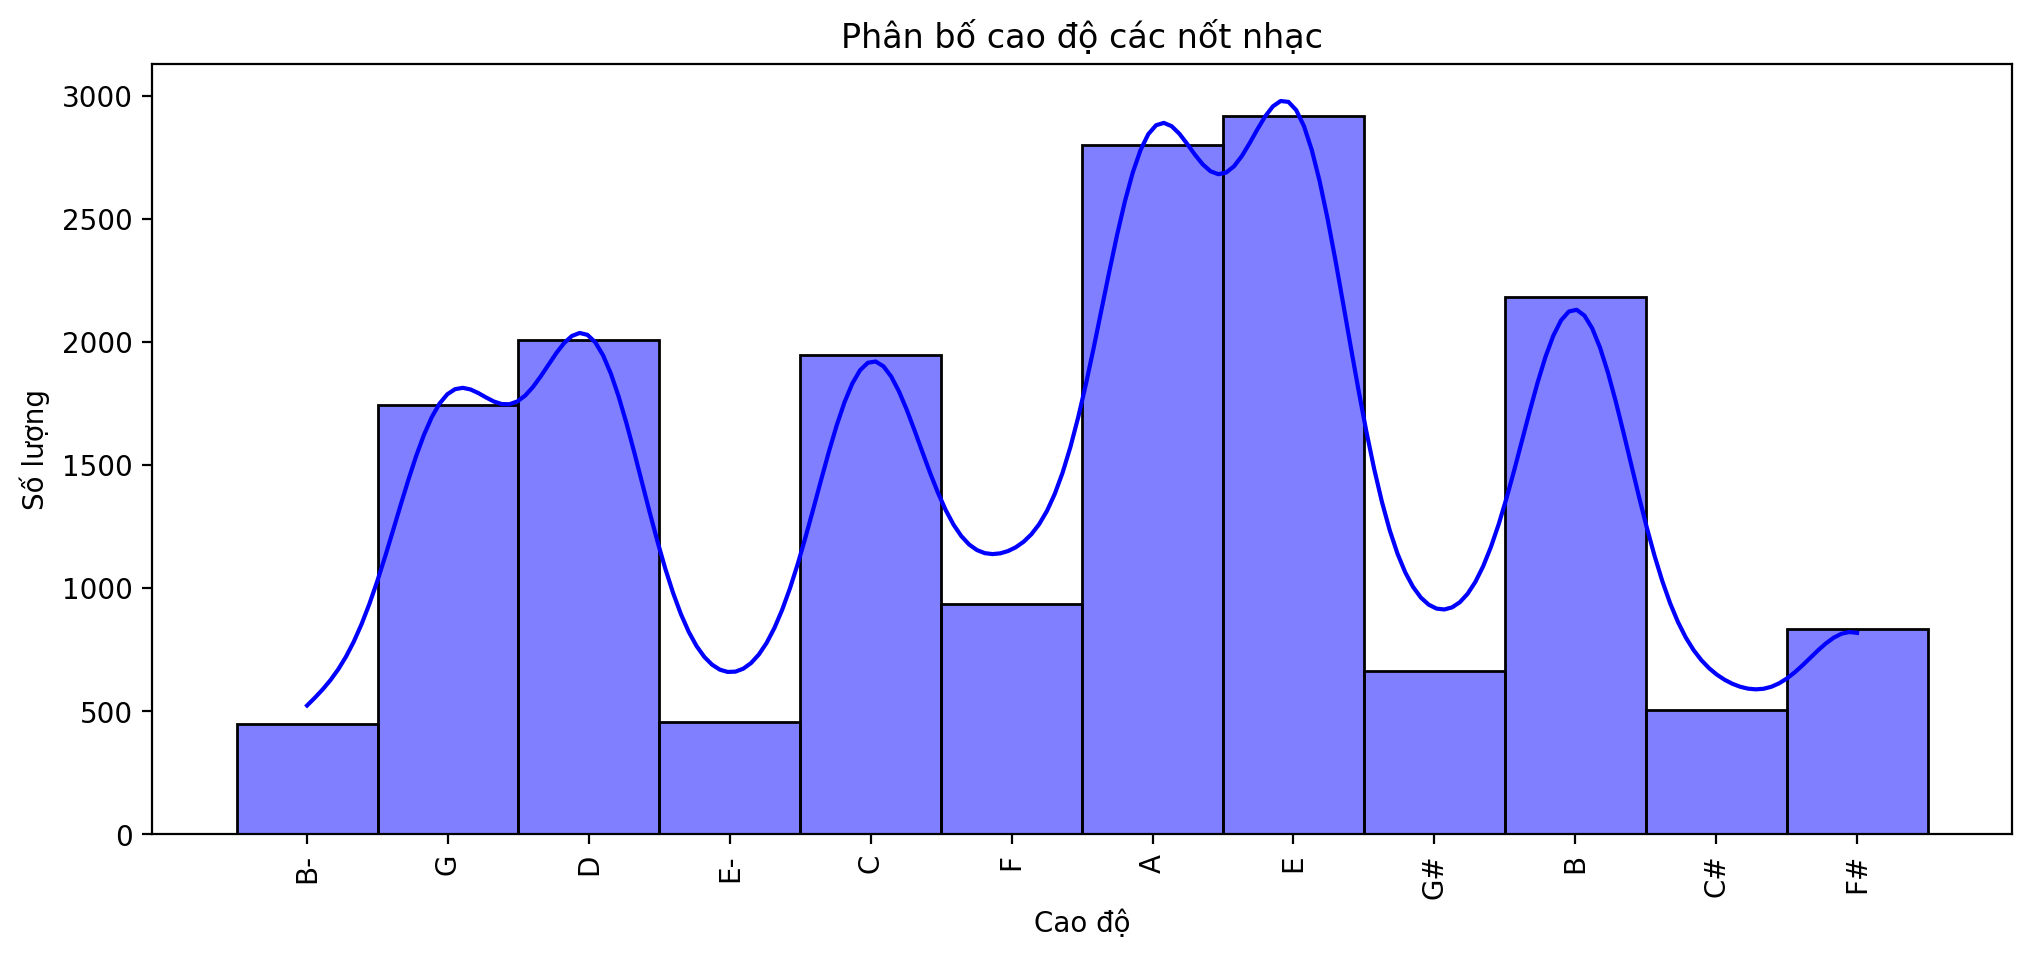

In [5]:
# Vẽ biểu đồ
plt.figure(figsize=(12, 5))
sns.histplot(df['pitch'], bins=30, kde=True, color='blue')
plt.title("Phân bố cao độ các nốt nhạc")
plt.xlabel("Cao độ")
plt.ylabel("Số lượng")
plt.xticks(rotation=90)
plt.show()


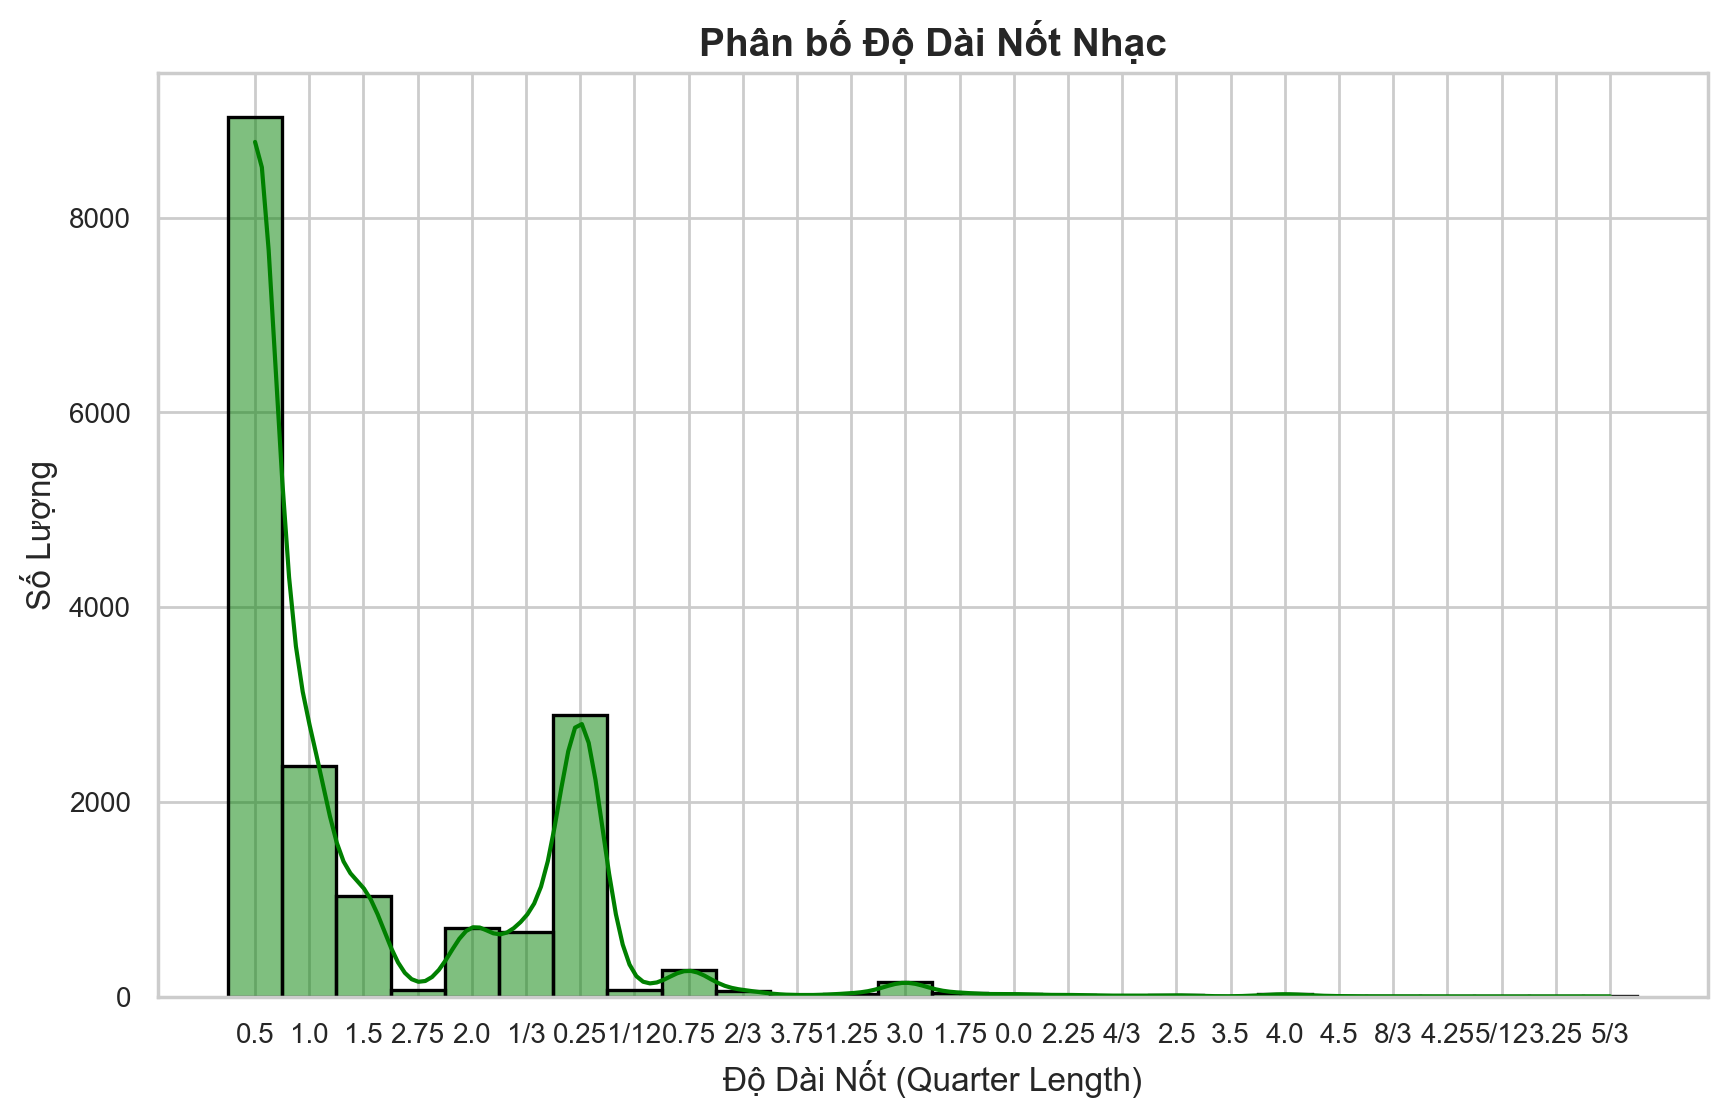

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Thiết lập phong cách
sns.set_theme(style="whitegrid")

# Vẽ biểu đồ phân bố độ dài nốt nhạc
plt.figure(figsize=(10, 6))
sns.histplot(df['duration'], bins=20, kde=True, color='green', edgecolor='black', linewidth=1.2)

# Tùy chỉnh nhãn và tiêu đề
plt.title("Phân bố Độ Dài Nốt Nhạc", fontsize=14, fontweight='bold')
plt.xlabel("Độ Dài Nốt (Quarter Length)", fontsize=12)
plt.ylabel("Số Lượng", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Hiển thị biểu đồ
plt.show()


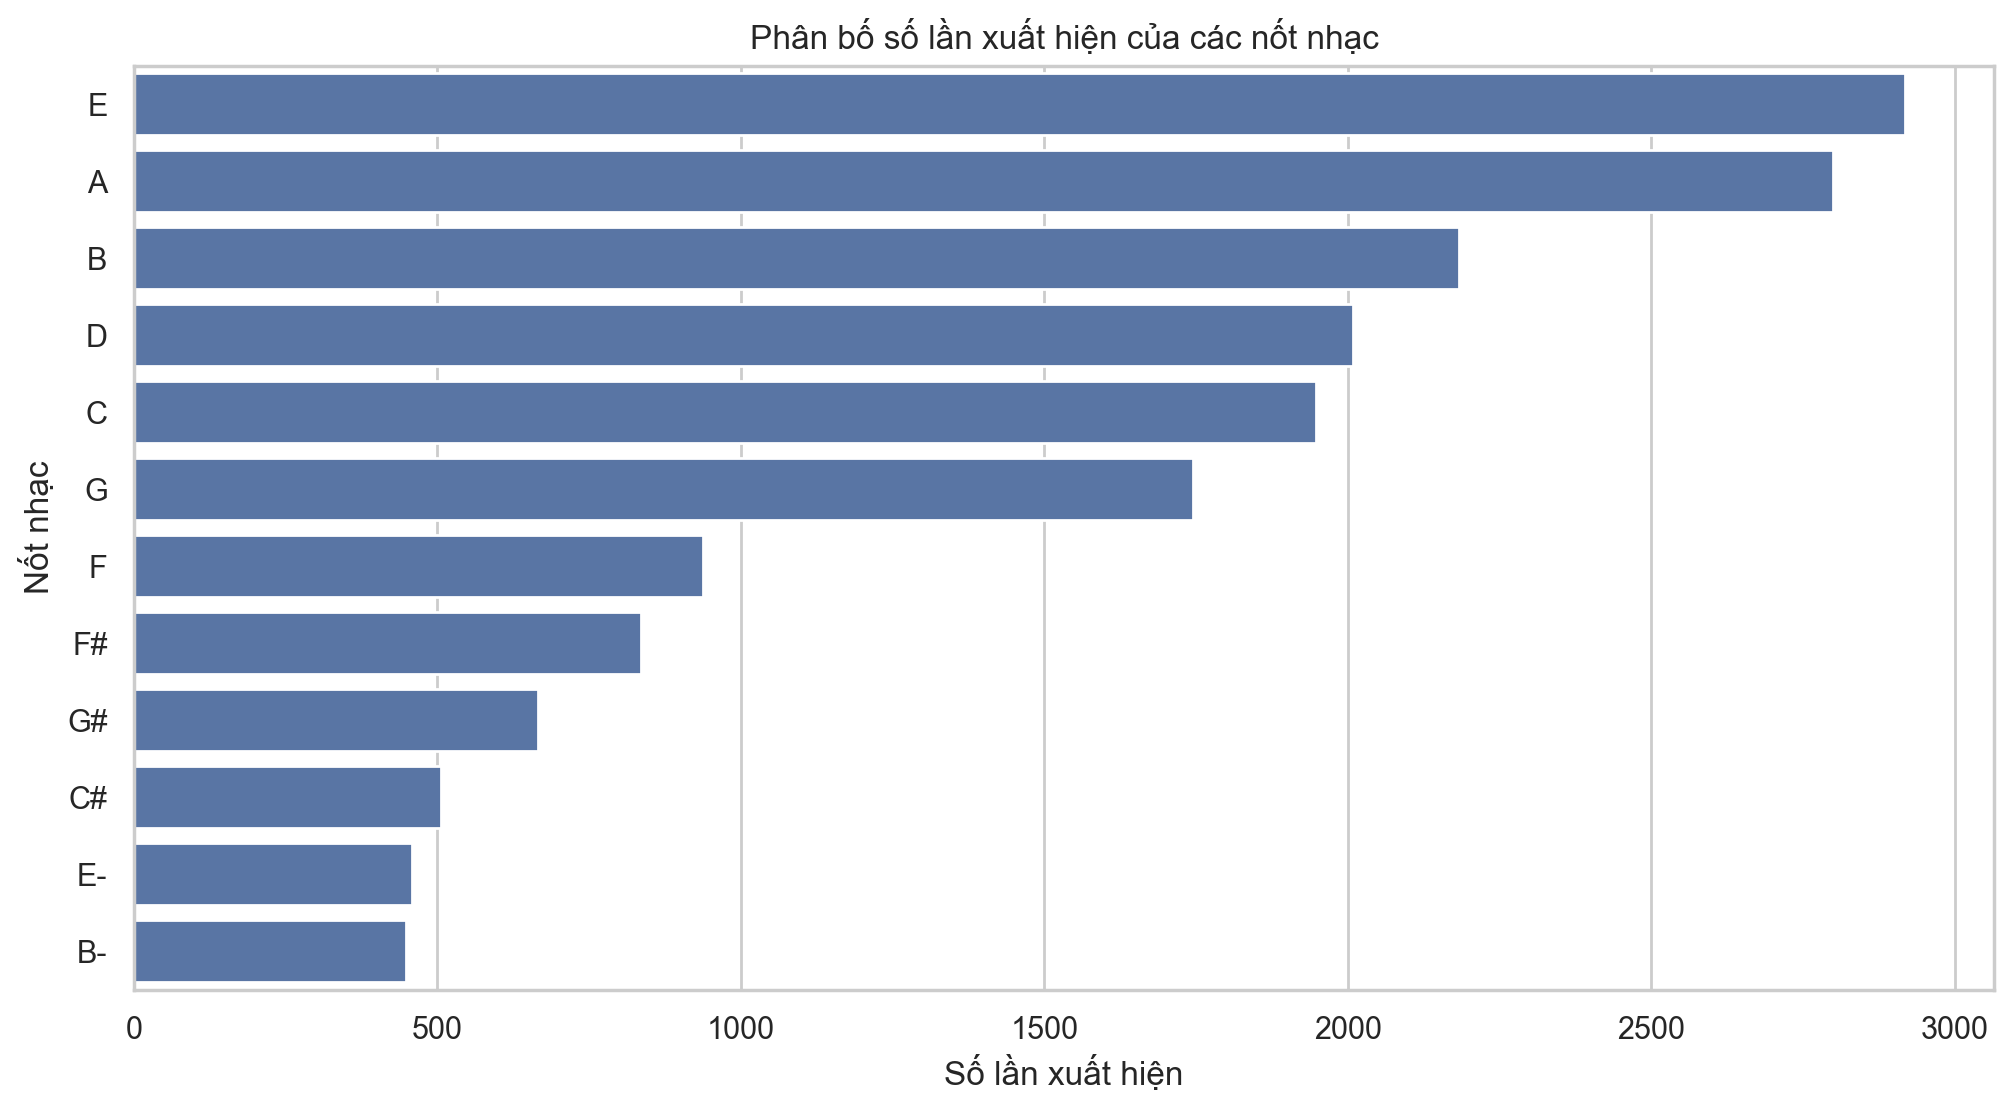

In [7]:
# **1. Phân bố cao độ của nốt nhạc**
plt.figure(figsize=(12, 6))
sns.countplot(y=df["pitch"], order=df["pitch"].value_counts().index)
plt.xlabel("Số lần xuất hiện")
plt.ylabel("Nốt nhạc")
plt.title("Phân bố số lần xuất hiện của các nốt nhạc")
plt.show()

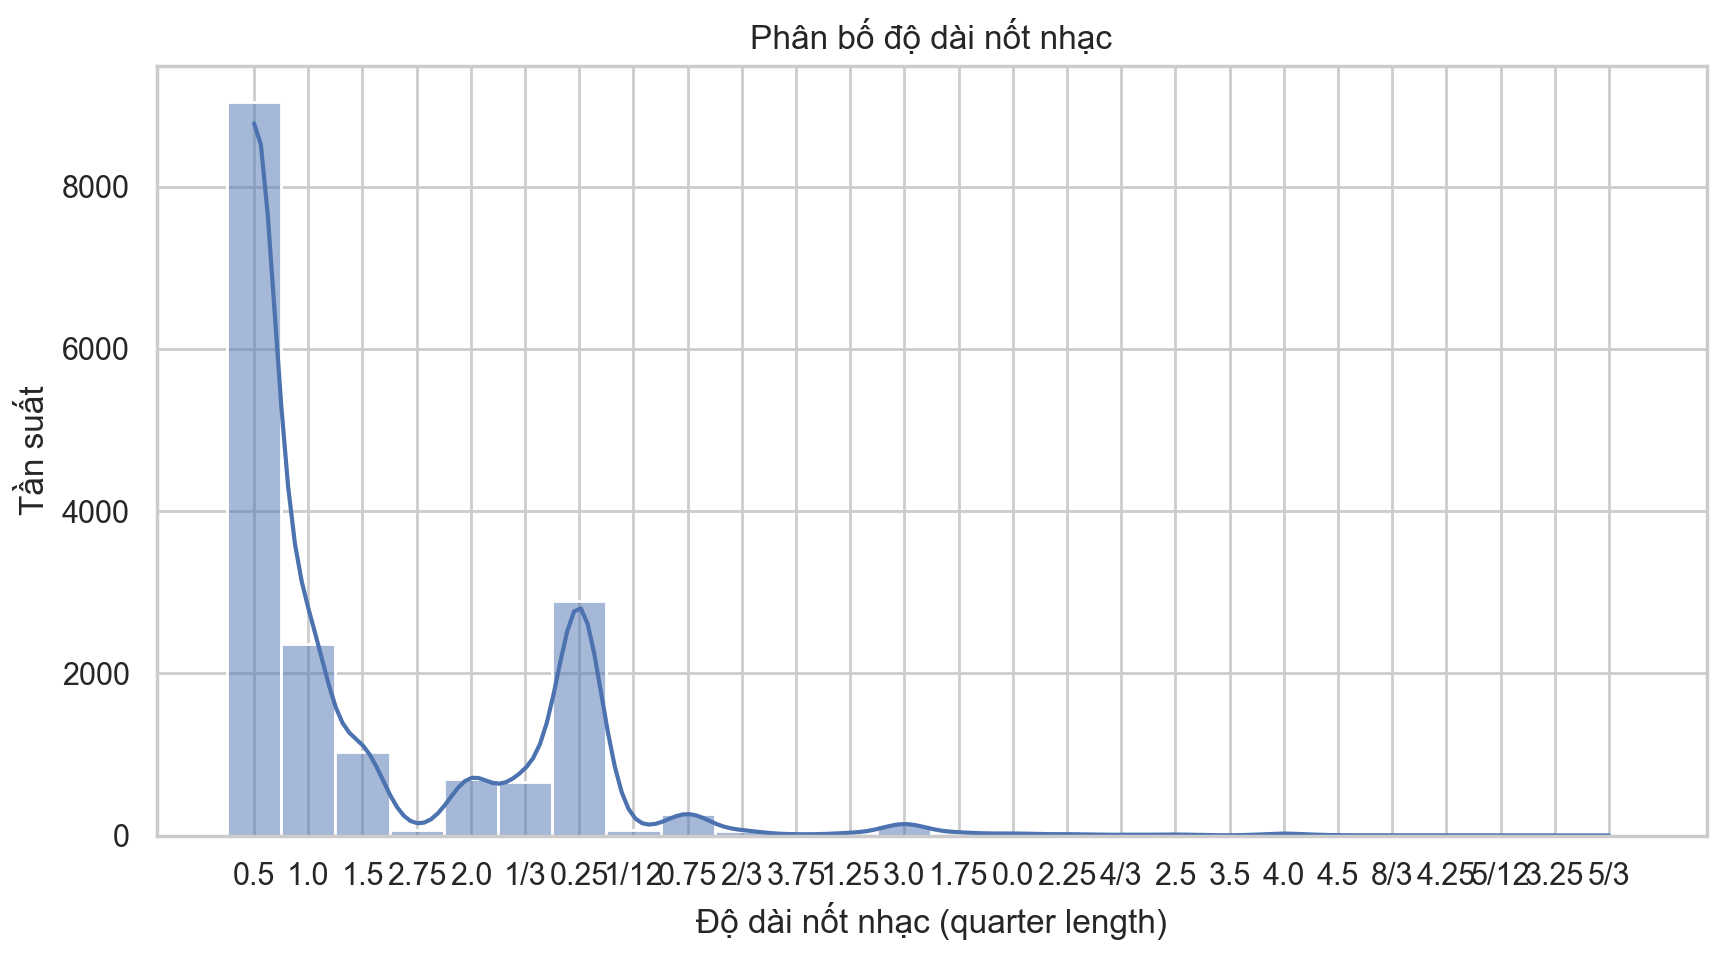

In [8]:
# **2. Phân bố độ dài của nốt nhạc**
plt.figure(figsize=(10, 5))
sns.histplot(df["duration"], bins=30, kde=True)
plt.xlabel("Độ dài nốt nhạc (quarter length)")
plt.ylabel("Tần suất")
plt.title("Phân bố độ dài nốt nhạc")
plt.show()

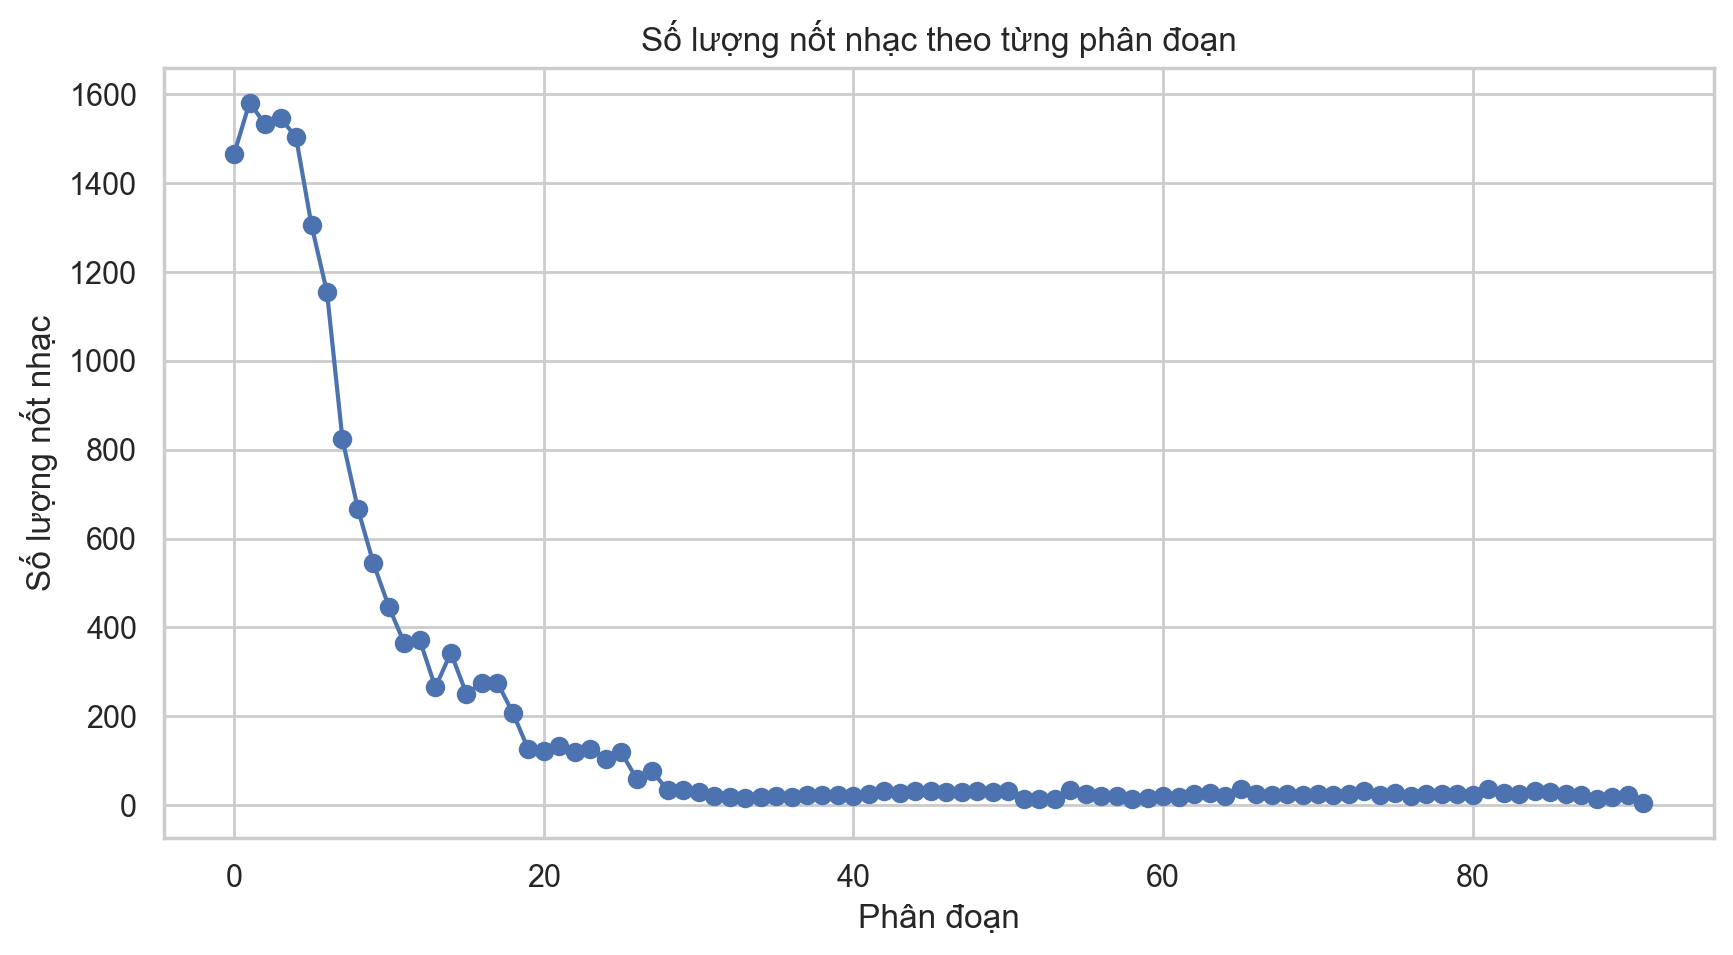

In [9]:
# **4. Số lượng nốt nhạc theo phân đoạn**
plt.figure(figsize=(10, 5))
df_segment_count = df.groupby("segment").size()
plt.plot(df_segment_count.index, df_segment_count.values, marker="o", linestyle="-")
plt.xlabel("Phân đoạn")
plt.ylabel("Số lượng nốt nhạc")
plt.title("Số lượng nốt nhạc theo từng phân đoạn")
plt.grid(True)
plt.show()

mô hình LSMT

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
# Load dữ liệu từ file pickle
with open("D:/CĐE/test/midi_data_music21.pkl", "rb") as f:
    loaded_data = pickle.load(f)

# Kiểm tra loại dữ liệu
print(f"Kiểu dữ liệu của loaded_data: {type(loaded_data)}")

# Nếu dữ liệu là danh sách, ta cần chuyển đổi đúng định dạng
if isinstance(loaded_data, dict):  
    midi_data = loaded_data["data"]
    note_to_int = loaded_data["note_to_int"]
elif isinstance(loaded_data, list):  
    midi_data = loaded_data  # Nếu file chỉ chứa danh sách dữ liệu MIDI
    # Tạo mapping note_to_int
    all_notes = sorted(set(note["pitch"] for song in midi_data for note in song))
    note_to_int = {note: i + 1 for i, note in enumerate(all_notes)}
else:
    raise ValueError("Lỗi: Dữ liệu trong file pickle không đúng định dạng!")

num_notes = len(note_to_int) + 1  # Thêm 1 để tránh lỗi khi mapping

# Chuyển đổi dữ liệu MIDI thành chuỗi huấn luyện
X, y = [], []
seq_length = 100  # Độ dài mỗi chuỗi huấn luyện

for song in midi_data:
    notes = np.array([note_to_int.get(note["pitch"], 0) for note in song])  # Mặc định 0 nếu không có trong mapping

    for i in range(len(notes) - seq_length):
        X.append(notes[i:i + seq_length])
        y.append(notes[i + seq_length])  # Nốt tiếp theo

X = np.array(X).reshape(len(X), seq_length, 1)  # Thêm chiều thứ 2 cho phù hợp với LSTM
y = np.array(y)
# chia tập dữ liệu
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")
# Xây dựng mô hình LSTM
model = Sequential([
    LSTM(256, return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(256, return_sequences=False),
    Dense(num_notes, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam",metrics=["accuracy"])

# Huấn luyện mô hình
history_lstm= model.fit(X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32)

# Lưu mô hình
model.save("D:/CĐE/test/music_generator_lstm.h5")

print("Huấn luyện hoàn tất và mô hình đã được lưu!")

Kiểu dữ liệu của loaded_data: <class 'list'>
Train: (17305, 100, 1), Validation: (3708, 100, 1), Test: (3709, 100, 1)


d:\CĐE\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
541/541 ━━━━━━━━━━━━━━━━━━━━ 258s 469ms/step - accuracy: 0.0730 - loss: 3.6419 - val_accuracy: 0.0930 - val_loss: 3.4721
Epoch 2/50
541/541 ━━━━━━━━━━━━━━━━━━━━ 267s 478ms/step - accuracy: 0.1100 - loss: 3.4148 - val_accuracy: 0.1303 - val_loss: 3.2743
Epoch 3/50
541/541 ━━━━━━━━━━━━━━━━━━━━ 232s 429ms/step - accuracy: 0.1452 - loss: 3.2090 - val_accuracy: 0.1683 - val_loss: 3.0903
Epoch 4/50
541/541 ━━━━━━━━━━━━━━━━━━━━ 205s 378ms/step - accuracy: 0.1923 - loss: 2.9791 - val_accuracy: 0.1958 - val_loss: 2.9498
Epoch 5/50
541/541 ━━━━━━━━━━━━━━━━━━━━ 209s 385ms/step - accuracy: 0.2349 - loss: 2.7725 - val_accuracy: 0.2109 - val_loss: 2.8738
Epoch 6/50
541/541 ━━━━━━━━━━━━━━━━━━━━ 209s 386ms/step - accuracy: 0.2781 - loss: 2.5937 - val_accuracy: 0.2567 - val_loss: 2.7359
Epoch 7/50
541/541 ━━━━━━━━━━━━━━━━━━━━ 256s 376ms/step - accuracy: 0.3175 - loss: 2.4222 - val_accuracy: 0.2786 - val_loss: 2.6248
Epoch 8/50
541/541 ━━━━━━━━━━━━━━━━━━━━ 207s 383ms/step - accuracy: 0.3799 -

Huấn luyện hoàn tất và mô hình đã được lưu!


In [ ]:

import random
# Load mô hình đã huấn luyện
model = load_model("D:/CĐE/test/music_generator_lstm.h5")

# Khởi tạo seed để sinh nhạc
start_index = random.randint(0, len(X_train) - 1)
seed_sequence = X_train[start_index]

generated_notes = []
num_generate = 100  # Số lượng nốt muốn sinh ra

# Sinh nhạc
for _ in range(num_generate):
    prediction_input = seed_sequence.reshape(1, seq_length, 1)
    predicted_index = np.argmax(model.predict(prediction_input, verbose=0))
    
    # Lưu lại nốt được sinh
    generated_notes.append(predicted_index)
    
    # Cập nhật seed_sequence đúng shape
    next_note = np.array([[predicted_index]])  # (1,1)
    seed_sequence = np.vstack((seed_sequence[1:], next_note))  # (seq_length,1)

# Đảo ngược lại từ chỉ số sang tên nốt
int_to_note = {i: note for note, i in note_to_int.items()}

# Tạo stream nhạc
output_notes = []
start_time = 0.0
duration = 0.5  # Giả định độ dài nốt cố định, bạn có thể random nhỏ để đa dạng hơn

for index in generated_notes:
    pitch = int_to_note.get(index, None)
    if pitch and pitch != "Rest":
        new_note = note.Note(pitch)
        new_note.offset = start_time
        new_note.quarterLength = duration
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)
    start_time += duration

# Tạo một bản nhạc MIDI mới
midi_stream = stream.Stream(output_notes)
midi_stream.write("midi", fp="D:/CĐE/test/generated_music_lstm.mid")
print("Đã sinh ra file MIDI")



Đã sinh ra file MIDI


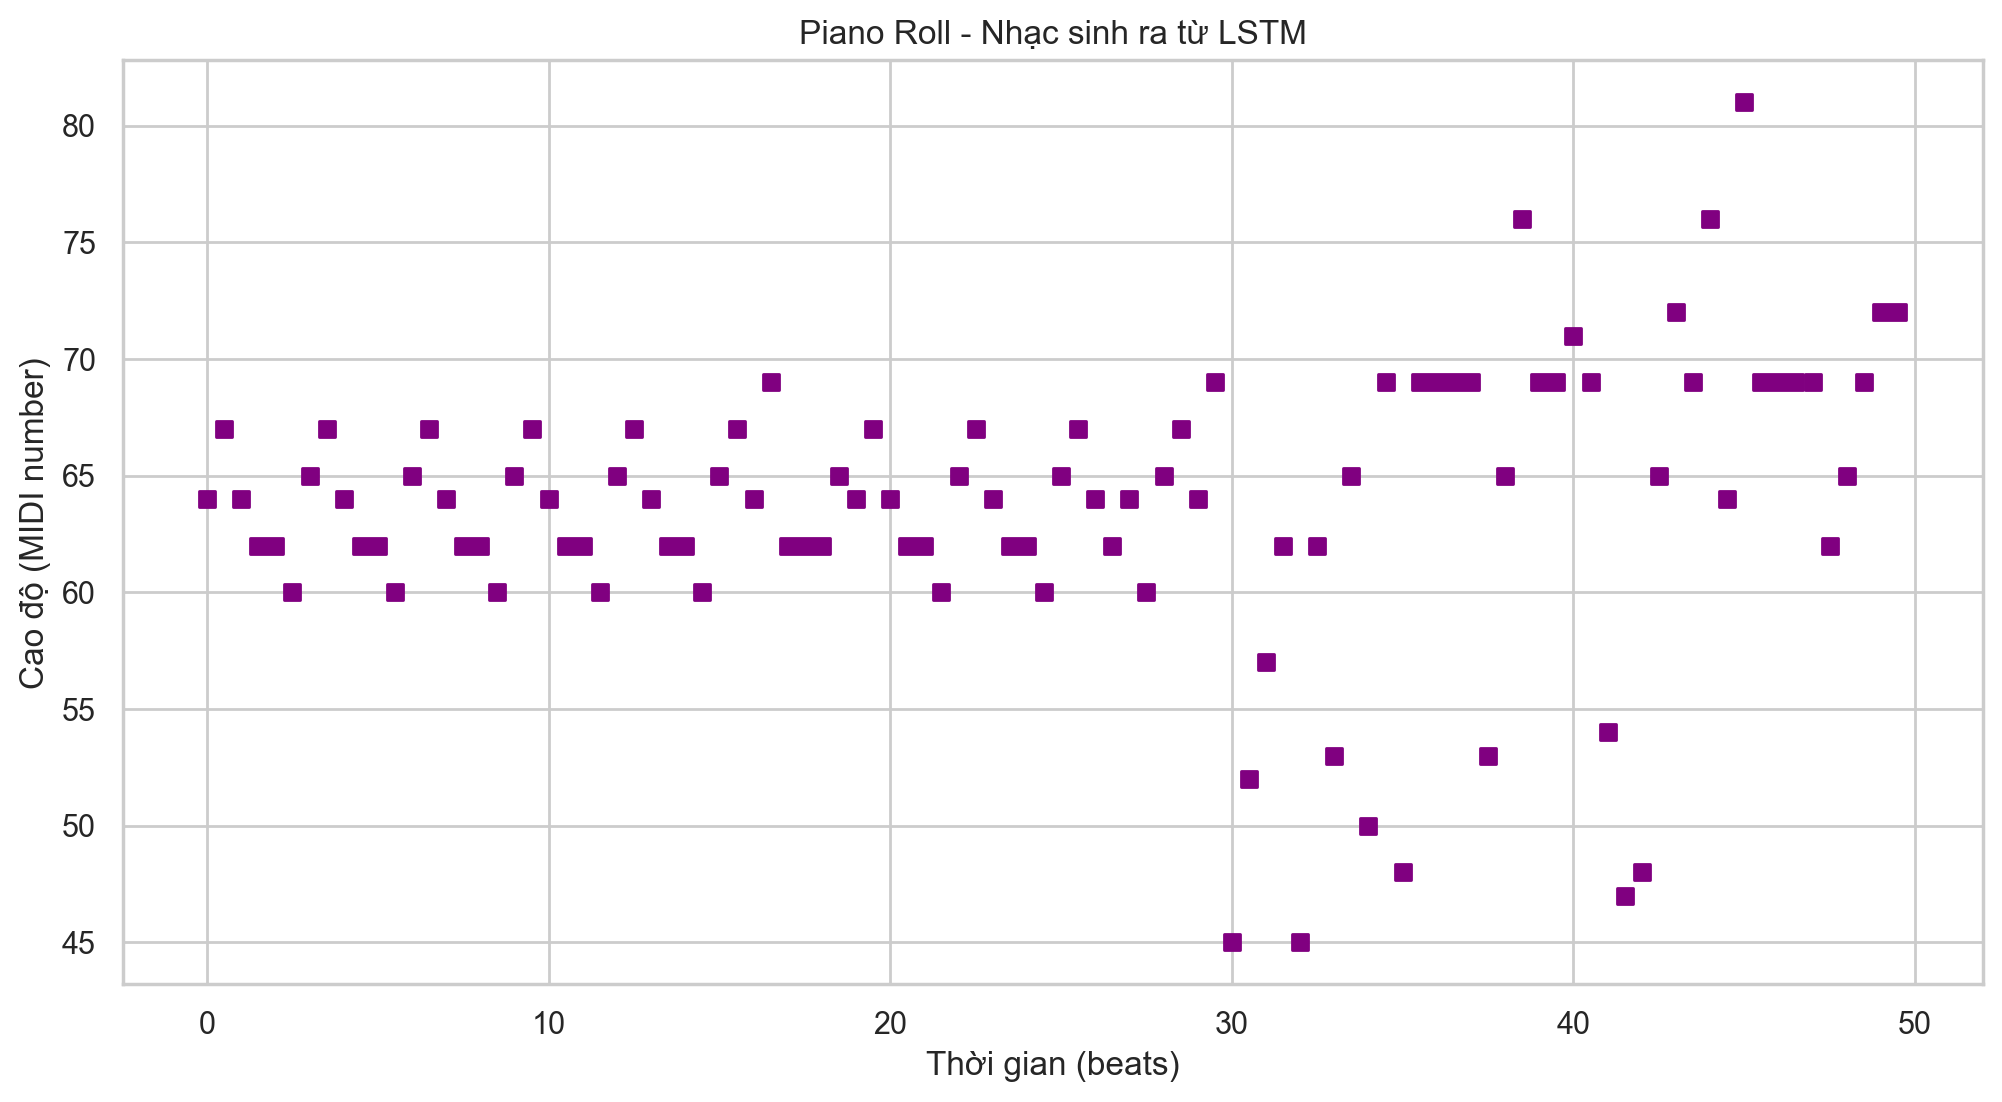

In [17]:
# Chuẩn bị dữ liệu piano roll
pitches = []
times = []

for n in output_notes:
    pitches.append(n.pitch.midi)
    times.append(n.offset)

plt.figure(figsize=(12, 6))
plt.scatter(times, pitches, marker="s", color="purple")
plt.xlabel("Thời gian (beats)")
plt.ylabel("Cao độ (MIDI number)")
plt.title("Piano Roll - Nhạc sinh ra từ LSTM")
plt.grid(True)
plt.show()


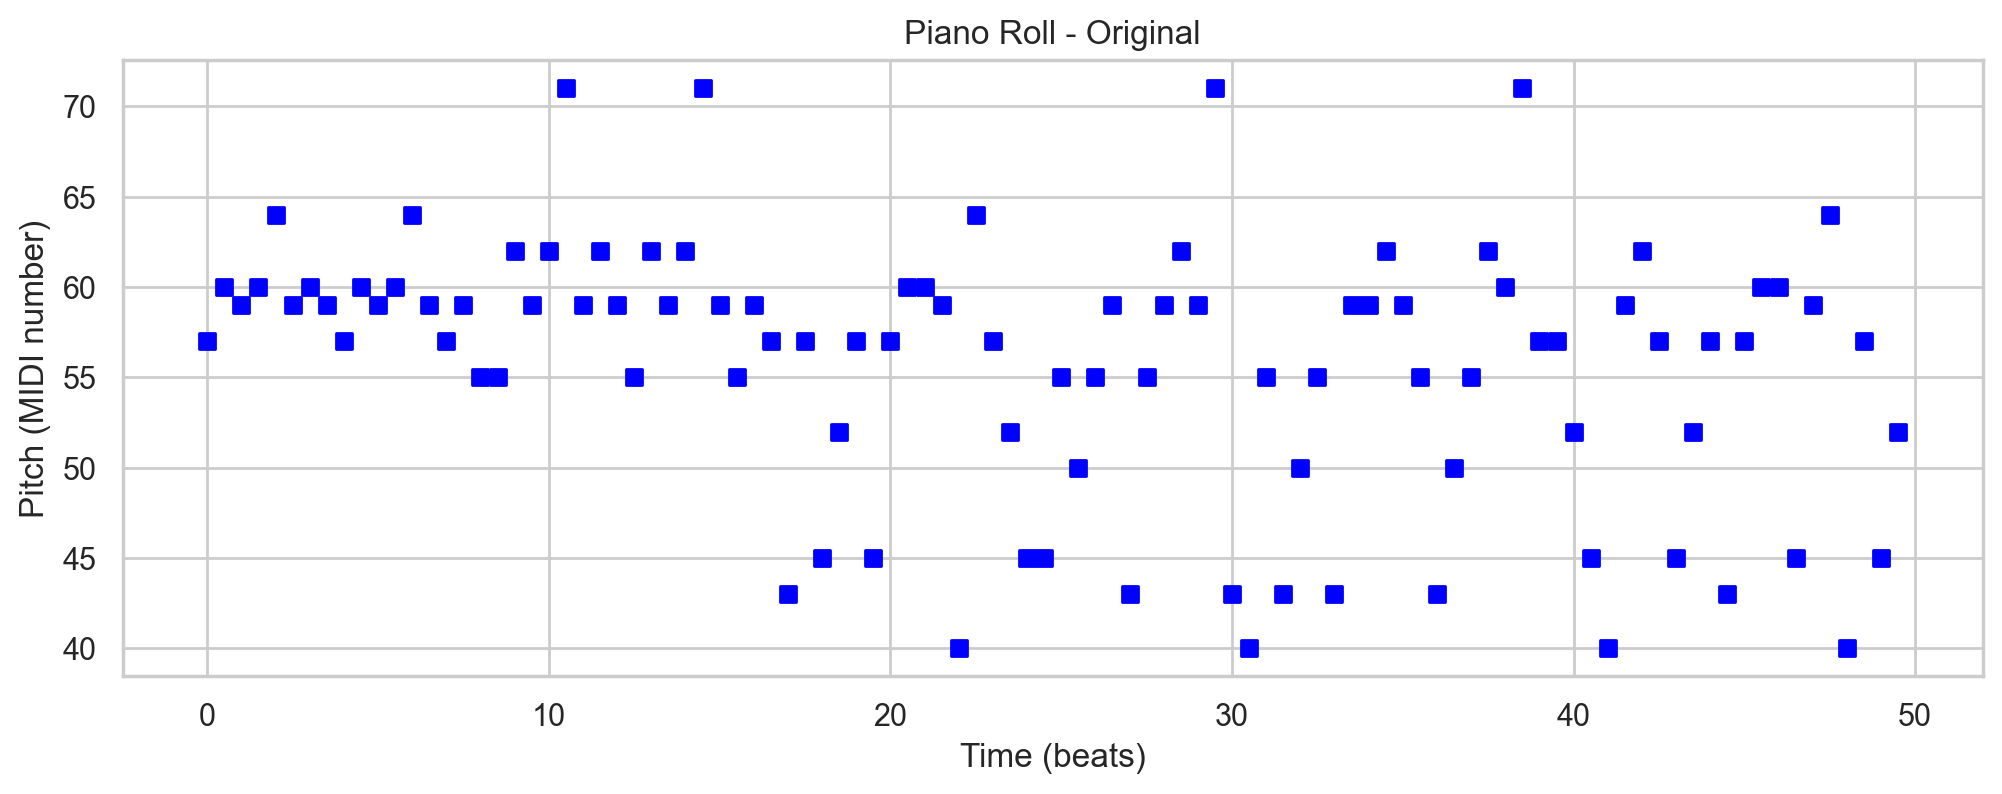

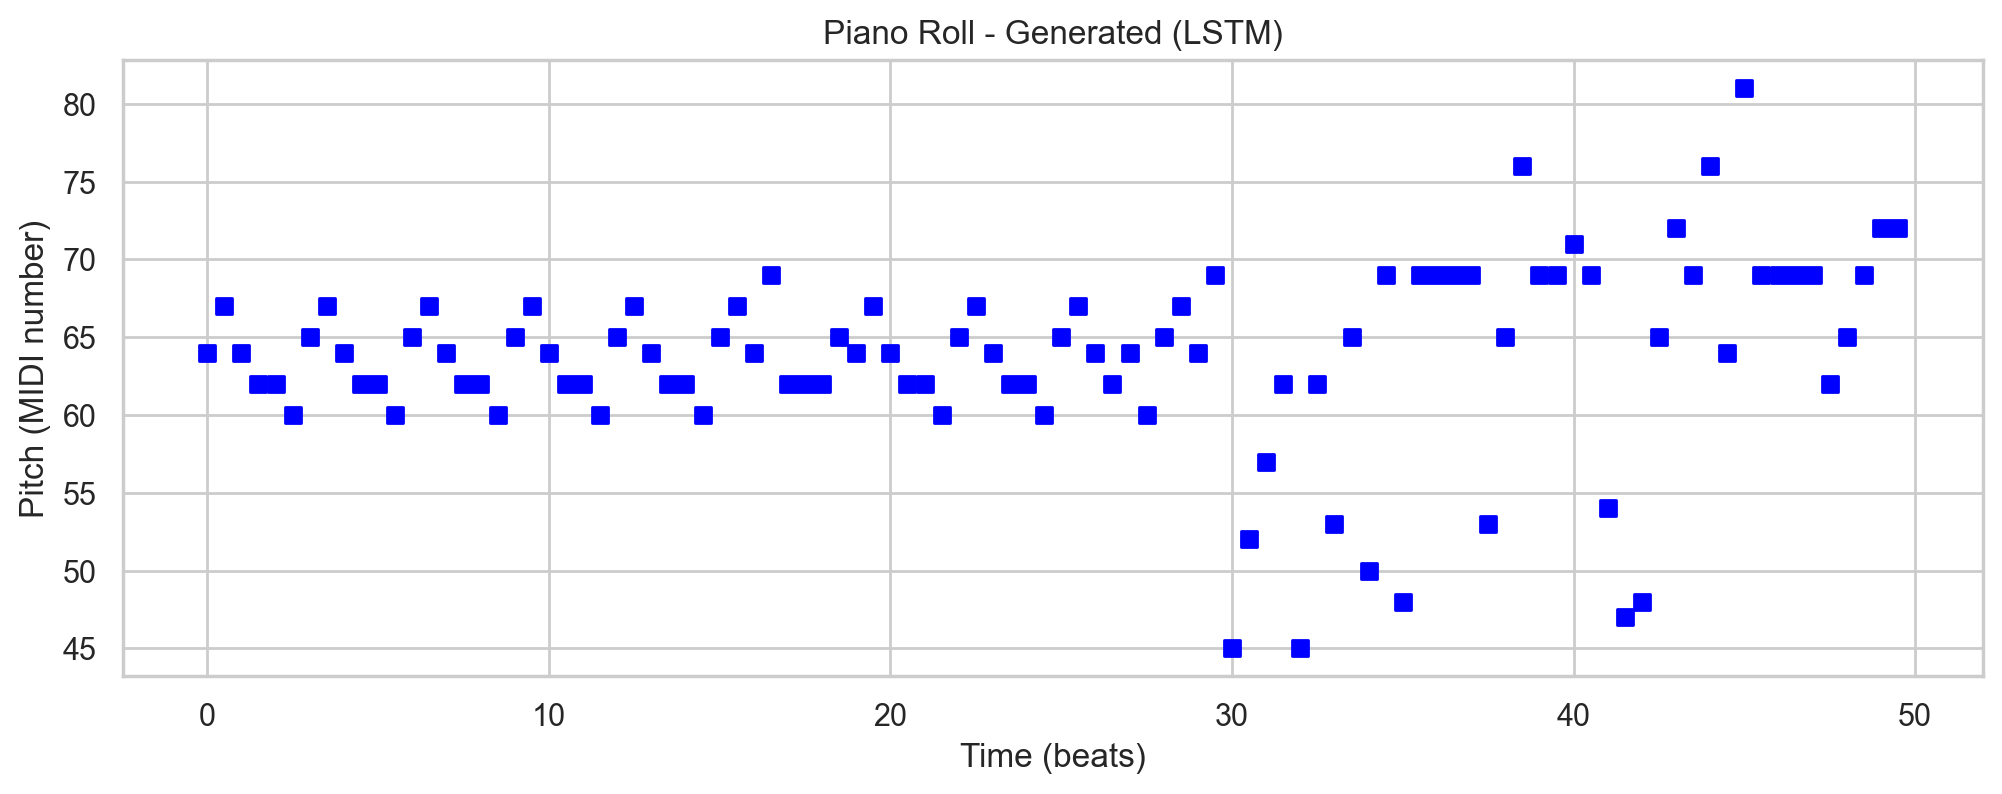

In [20]:
import matplotlib.pyplot as plt

def plot_piano_roll(note_sequence, title="Piano Roll", duration_per_note=0.5):
    """
    Vẽ biểu đồ piano roll đơn giản cho danh sách pitch (chuỗi nốt).
    note_sequence: danh sách pitch (dưới dạng string, ví dụ "C4", "D#4", ...)
    """
    # Chuyển pitch string thành MIDI number để dễ vẽ (nốt cao hơn số lớn hơn)
    pitches = []
    times = []
    for idx, pitch in enumerate(note_sequence):
        try:
            midi_number = note.Note(pitch).pitch.midi
            pitches.append(midi_number)
            times.append(idx * duration_per_note)
        except:
            continue  # Bỏ qua nếu pitch không hợp lệ
    
    plt.figure(figsize=(12, 4))
    plt.scatter(times, pitches, marker='s', c='blue')
    plt.xlabel("Time (beats)")
    plt.ylabel("Pitch (MIDI number)")
    plt.title(title)
    plt.grid(True)
    plt.show()
# Chuỗi nhạc gốc (trích từ bài đầu tiên)
original_sequence = [note["pitch"] for note in midi_data[1][:100]]

# Chuỗi nhạc sinh ra từ mô hình (đã có ở biến generated_notes)
generated_sequence = [int_to_note[n] for n in generated_notes if n in int_to_note]

# Vẽ biểu đồ
plot_piano_roll(original_sequence, title="Piano Roll - Original")
plot_piano_roll(generated_sequence, title="Piano Roll - Generated (LSTM)")



In [21]:
# Load dữ liệu
with open("D:/CĐE/test/midi_data_music21.pkl", "rb") as f:
    loaded_data = pickle.load(f)

if isinstance(loaded_data, dict):  
    midi_data = loaded_data["data"]
else:
    midi_data = loaded_data

# Kết hợp pitch và duration
all_tokens = sorted(set(f"{note['pitch']}_{note['duration']}" for song in midi_data for note in song))
token_to_int = {token: i+1 for i, token in enumerate(all_tokens)}
int_to_token = {i+1: token for token, i in token_to_int.items()}
vocab_size = len(token_to_int) + 1

# Chuyển đổi thành chuỗi
seq_length = 100
X, y = [], []

for song in midi_data:
    tokens = [token_to_int[f"{note['pitch']}_{note['duration']}"] for note in song]
    for i in range(len(tokens) - seq_length):
        X.append(tokens[i:i+seq_length])
        y.append(tokens[i+seq_length])

X = np.array(X)
y = np.array(y)

# Chia tập dữ liệu
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [23]:
from tensorflow.keras.layers import BatchNormalization
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=100, input_length=seq_length),
    LSTM(256, return_sequences=True),
    Dropout(0.3),
    BatchNormalization(),

    LSTM(256),
    Dropout(0.3),
    BatchNormalization(),

    Dense(vocab_size, activation="softmax")
])

model.build(input_shape=(None, seq_length))  # <- thêm dòng này
model.compile(optimizer=Adam(learning_rate=0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

history_lstm_1= model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=64)

model.save("D:/CĐE/test/music_generator_lstm_v2.h5")


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 100)       │        64,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 100, 256)       │       365,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 256)            │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 644)            │       165,508 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,122,836 (4.28 MB)

 Trainable params: 1,121,812 (4.28 MB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/50
271/271 ━━━━━━━━━━━━━━━━━━━━ 200s 713ms/step - accuracy: 0.0683 - loss: 5.5005 - val_accuracy: 0.0423 - val_loss: 5.0830
Epoch 2/50
271/271 ━━━━━━━━━━━━━━━━━━━━ 193s 711ms/step - accuracy: 0.1389 - loss: 3.9913 - val_accuracy: 0.1586 - val_loss: 3.8168
Epoch 3/50
271/271 ━━━━━━━━━━━━━━━━━━━━ 192s 709ms/step - accuracy: 0.2256 - loss: 3.3576 - val_accuracy: 0.2292 - val_loss: 3.3271
Epoch 4/50
271/271 ━━━━━━━━━━━━━━━━━━━━ 192s 707ms/step - accuracy: 0.2906 - loss: 2.9239 - val_accuracy: 0.2802 - val_loss: 3.1191
Epoch 5/50
271/271 ━━━━━━━━━━━━━━━━━━━━ 192s 708ms/step - accuracy: 0.3604 - loss: 2.5730 - val_accuracy: 0.3244 - val_loss: 2.9564
Epoch 6/50
271/271 ━━━━━━━━━━━━━━━━━━━━ 201s 703ms/step - accuracy: 0.4164 - loss: 2.2770 - val_accuracy: 0.3638 - val_loss: 2.7834
Epoch 7/50
271/271 ━━━━━━━━━━━━━━━━━━━━ 191s 706ms/step - accuracy: 0.4741 - loss: 1.9865 - val_accuracy: 0.3924 - val_loss: 2.6965
Epoch 8/50
271/271 ━━━━━━━━━━━━━━━━━━━━ 193s 711ms/step - accuracy: 0.5243 -

In [43]:
import random

# Load mô hình đã huấn luyện
model = load_model("D:/CĐE/test/music_generator_lstm_v2.h5")

# Giả sử bạn đã có X_train, seq_length và note_to_int
# Lấy một seed ngẫu nhiên từ dữ liệu huấn luyện
start_index = random.randint(0, len(X_train) - 1)
seed_sequence = X_train[start_index]  # shape: (seq_length, 1)

# Số lượng nốt sinh ra
num_generate = 90

# Ánh xạ ngược từ chỉ số về tên nốt
int_to_note = {i: note for note, i in note_to_int.items()}

generated_notes = []

for _ in range(num_generate):
    # reshape input về đúng định dạng (1, seq_length, 1)
    prediction_input = seed_sequence.reshape(1, seed_sequence.shape[0], 1)

    # Dự đoán nốt tiếp theo
    predicted_index = np.argmax(model.predict(prediction_input, verbose=0))
    generated_notes.append(predicted_index)

    # Cập nhật chuỗi seed: bỏ nốt đầu, thêm nốt mới
    next_note = np.array([[predicted_index]])  # shape (1, 1)
    seed_sequence = np.concatenate((seed_sequence[1:].reshape(-1, 1), next_note), axis=0)


# Tạo MIDI từ các nốt đã sinh
output_notes = []
start_time = 0.0
note_duration = 0.5  # quarterLength = 0.5 → 1 nốt = 0.25 giây

for index in generated_notes:
    pitch = int_to_note.get(index, None)
    if pitch and pitch != "Rest":
        new_note = note.Note(pitch)
        new_note.offset = start_time
        new_note.quarterLength = note_duration
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)
    start_time += note_duration

# Tạo stream nhạc và thêm tempo
midi_stream = stream.Stream()
midi_stream.append(tempo.MetronomeMark(number=80))
for n in output_notes:
    midi_stream.append(n)

# Xuất ra file MIDI
output_path = "D:/CĐE/test/generated_music_lstm_2.mid"
midi_stream.write("midi", fp=output_path)
print(f"Đã sinh nhạc và lưu tại: {output_path}")



Đã sinh nhạc và lưu tại: D:/CĐE/test/generated_music_lstm_2.mid


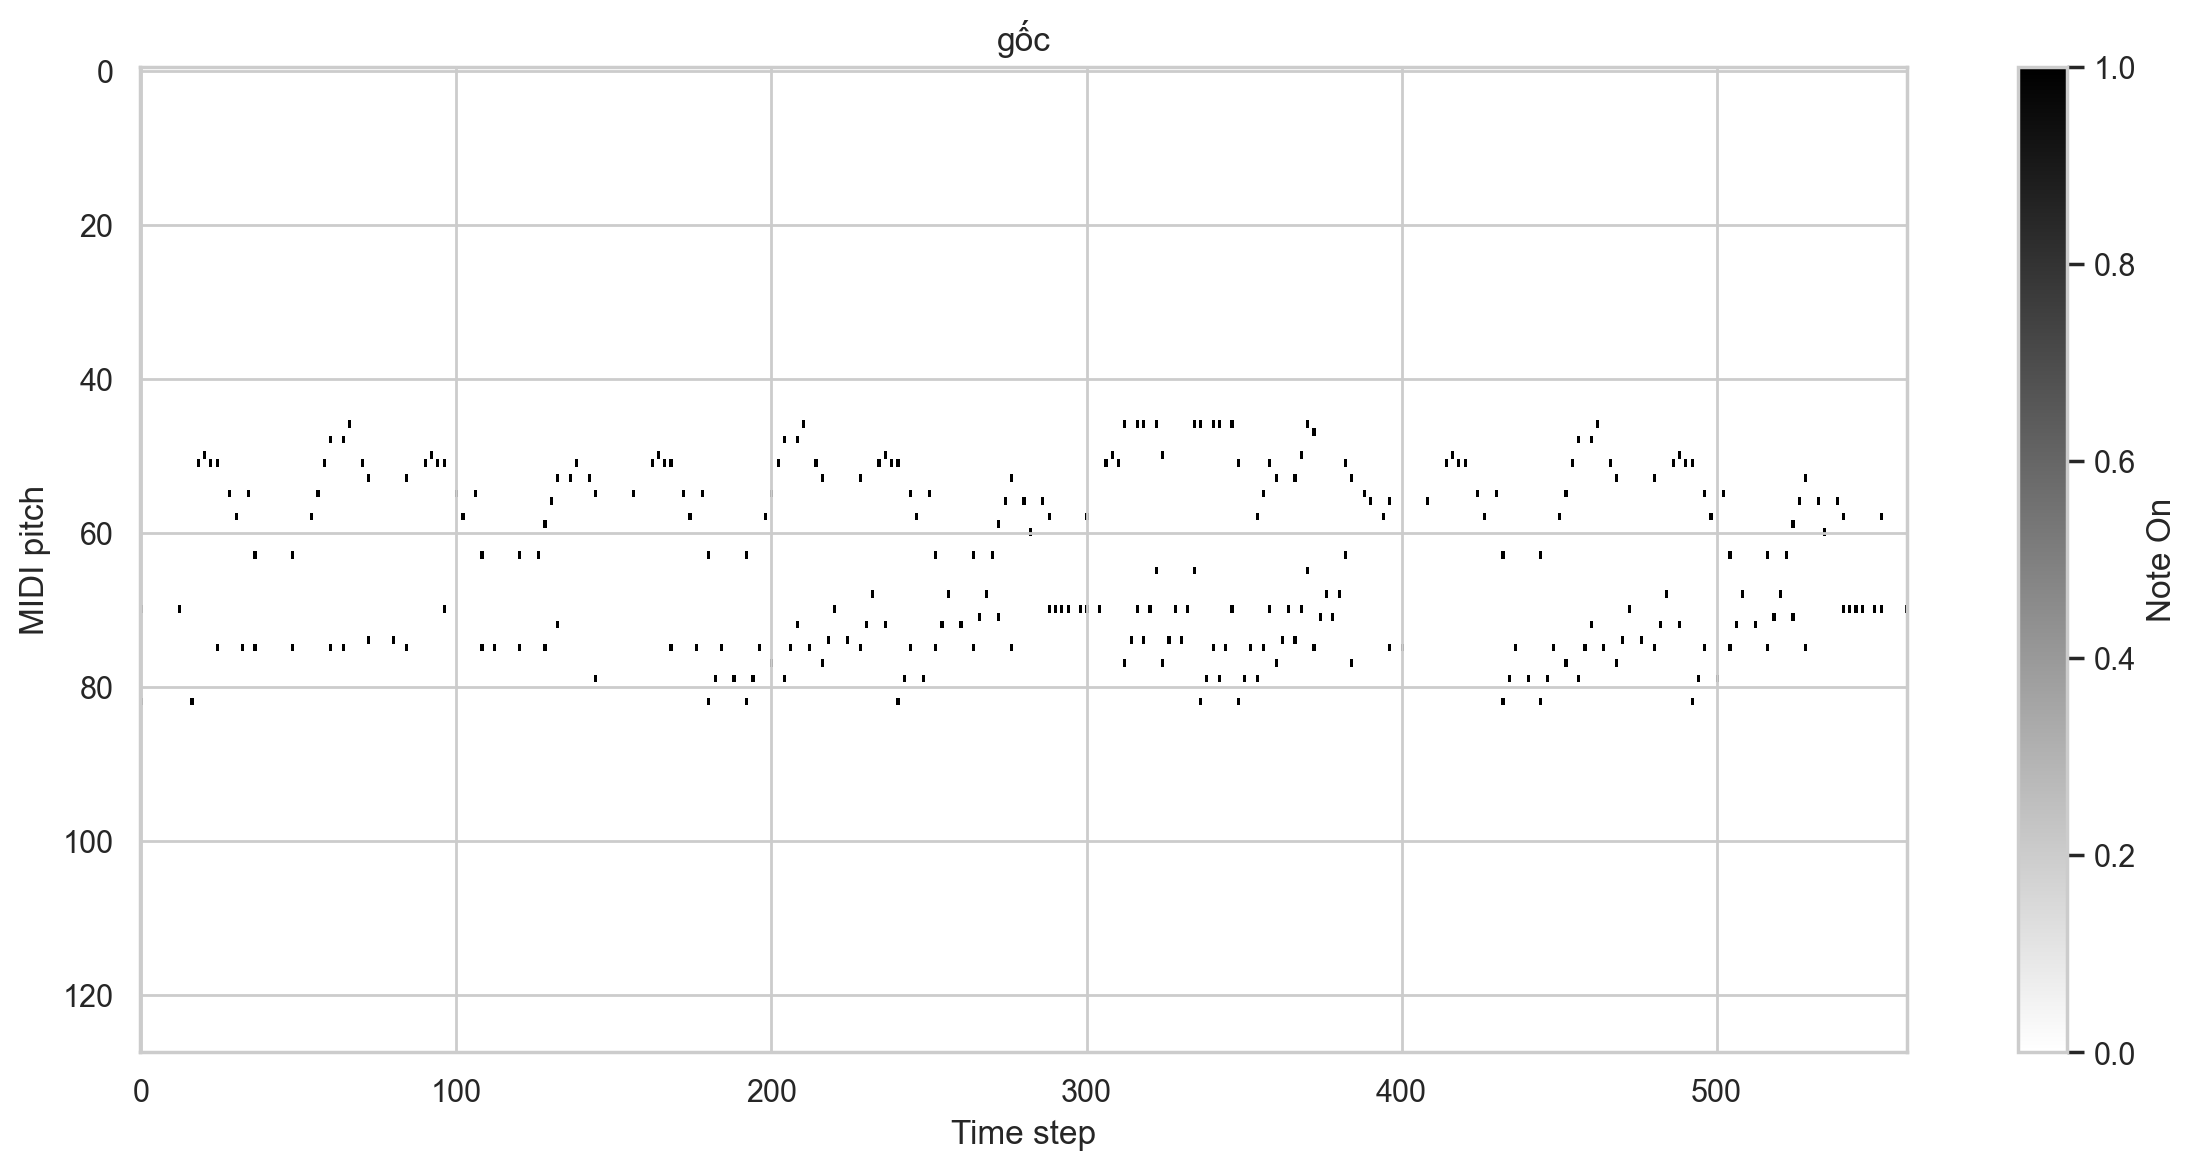

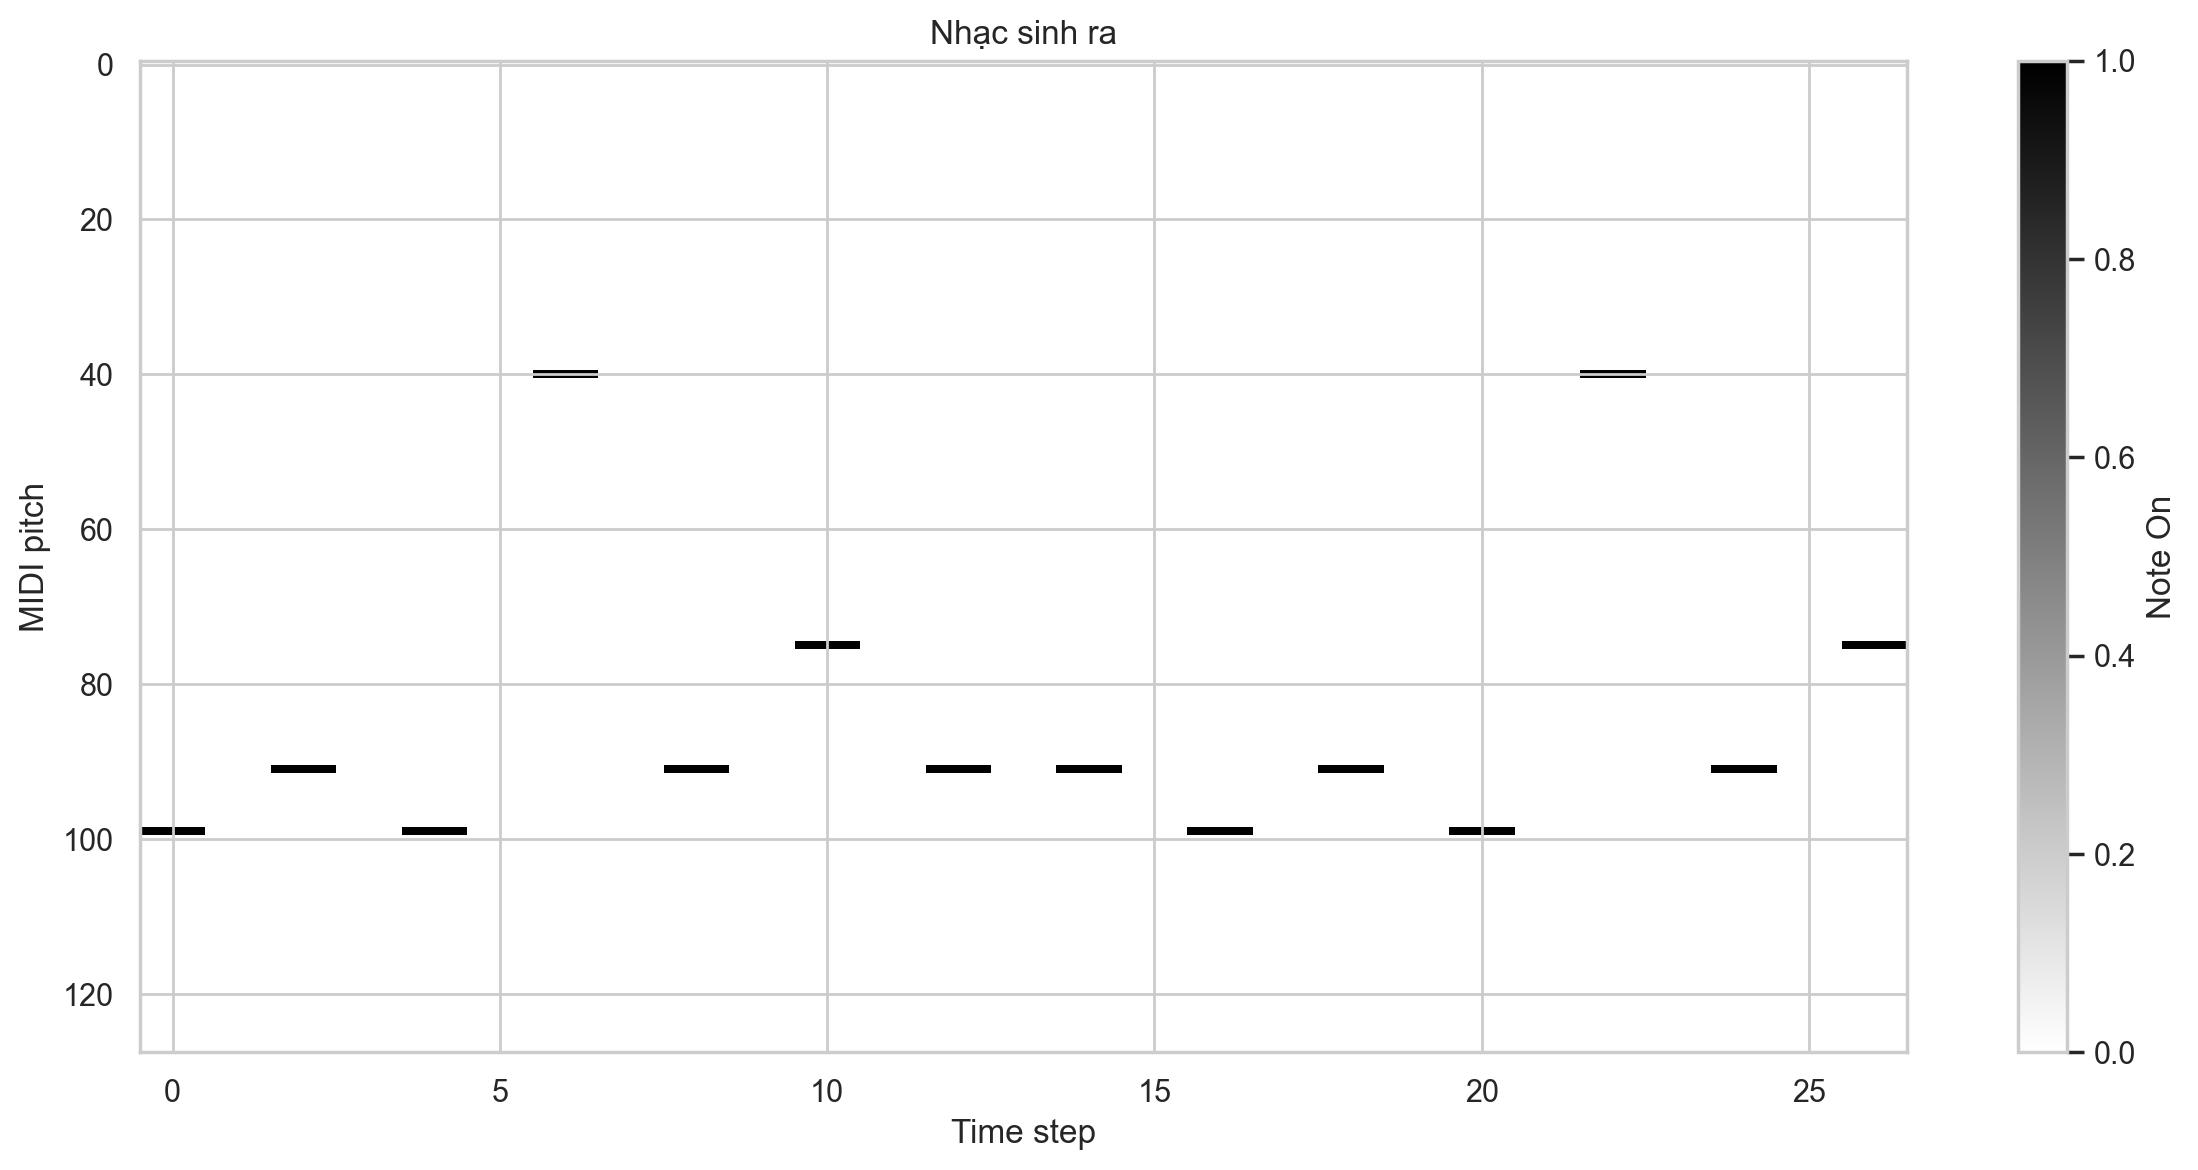

In [47]:
def extract_notes_from_midi(midi_path):
    midi = converter.parse(midi_path)

    parts = instrument.partitionByInstrument(midi)
    if parts:  # nếu có nhiều nhạc cụ
        notes = parts.parts[0].recurse()
    else:
        notes = midi.flat.notes

    extracted_notes = []
    for element in notes:
        if isinstance(element, note.Note):
            extracted_notes.append((element.offset, element.pitch.midi))
        elif isinstance(element, chord.Chord):
            # Với chord, lấy pitch trung bình (hoặc chọn nốt cao nhất/thấp nhất)
            extracted_notes.append((element.offset, element.pitches[0].midi))
    return extracted_notes

def build_piano_roll(note_events, time_resolution=0.25):
    """
    Tạo piano roll từ danh sách (offset, pitch)
    """
    if not note_events:
        return np.zeros((128, 1))

    max_time = max([offset for offset, pitch in note_events])
    num_steps = int(max_time / time_resolution) + 1
    piano_roll = np.zeros((128, num_steps))  # MIDI range: 0-127

    for offset, pitch in note_events:
        time_idx = int(offset / time_resolution)
        if 0 <= pitch < 128:
            piano_roll[pitch, time_idx] = 1
    return piano_roll

def plot_piano_roll(piano_roll, title="Piano Roll"):
    plt.figure(figsize=(12, 6))
    plt.imshow(piano_roll[::-1], aspect='auto', cmap='gray_r', interpolation='nearest')
    plt.title(title)
    plt.xlabel("Time step")
    plt.ylabel("MIDI pitch")
    plt.colorbar(label="Note On")
    plt.tight_layout()
    plt.show()


# 🔍 Đường dẫn đến file MIDI gốc và MIDI sinh ra
midi_real_path = "D:/CĐE/data/Diễm xưa.mid"  # ← thay bằng file nhạc gốc bạn muốn so sánh
midi_generated_path = "D:/CĐE/test/generated_music_lstm_2.mid"

# 📥 Trích xuất nốt
notes_real = extract_notes_from_midi(midi_real_path)
notes_generated = extract_notes_from_midi(midi_generated_path)

piano_roll_real = build_piano_roll(notes_real)
piano_roll_generated = build_piano_roll(notes_generated)
plot_piano_roll(piano_roll_real, title="gốc")
plot_piano_roll(piano_roll_generated, title="Nhạc sinh ra")


🔎 So sánh thống kê giữa nhạc gốc và nhạc sinh:
Số lượng nốt:		100 (gốc) vs 14 (sinh)
Cao độ trung bình:	63.69 (gốc) vs 43.29 (sinh)
Độ dài bài hát:		50.00 s (gốc) vs 7.00 s (sinh)
Số cao độ khác nhau:	18 (gốc) vs 4 (sinh)


C:\Users\VuNgoc\AppData\Local\Temp\ipykernel_12192\3464485402.py:64: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from font(s) Arial.
  plt.tight_layout()
d:\CĐE\myenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


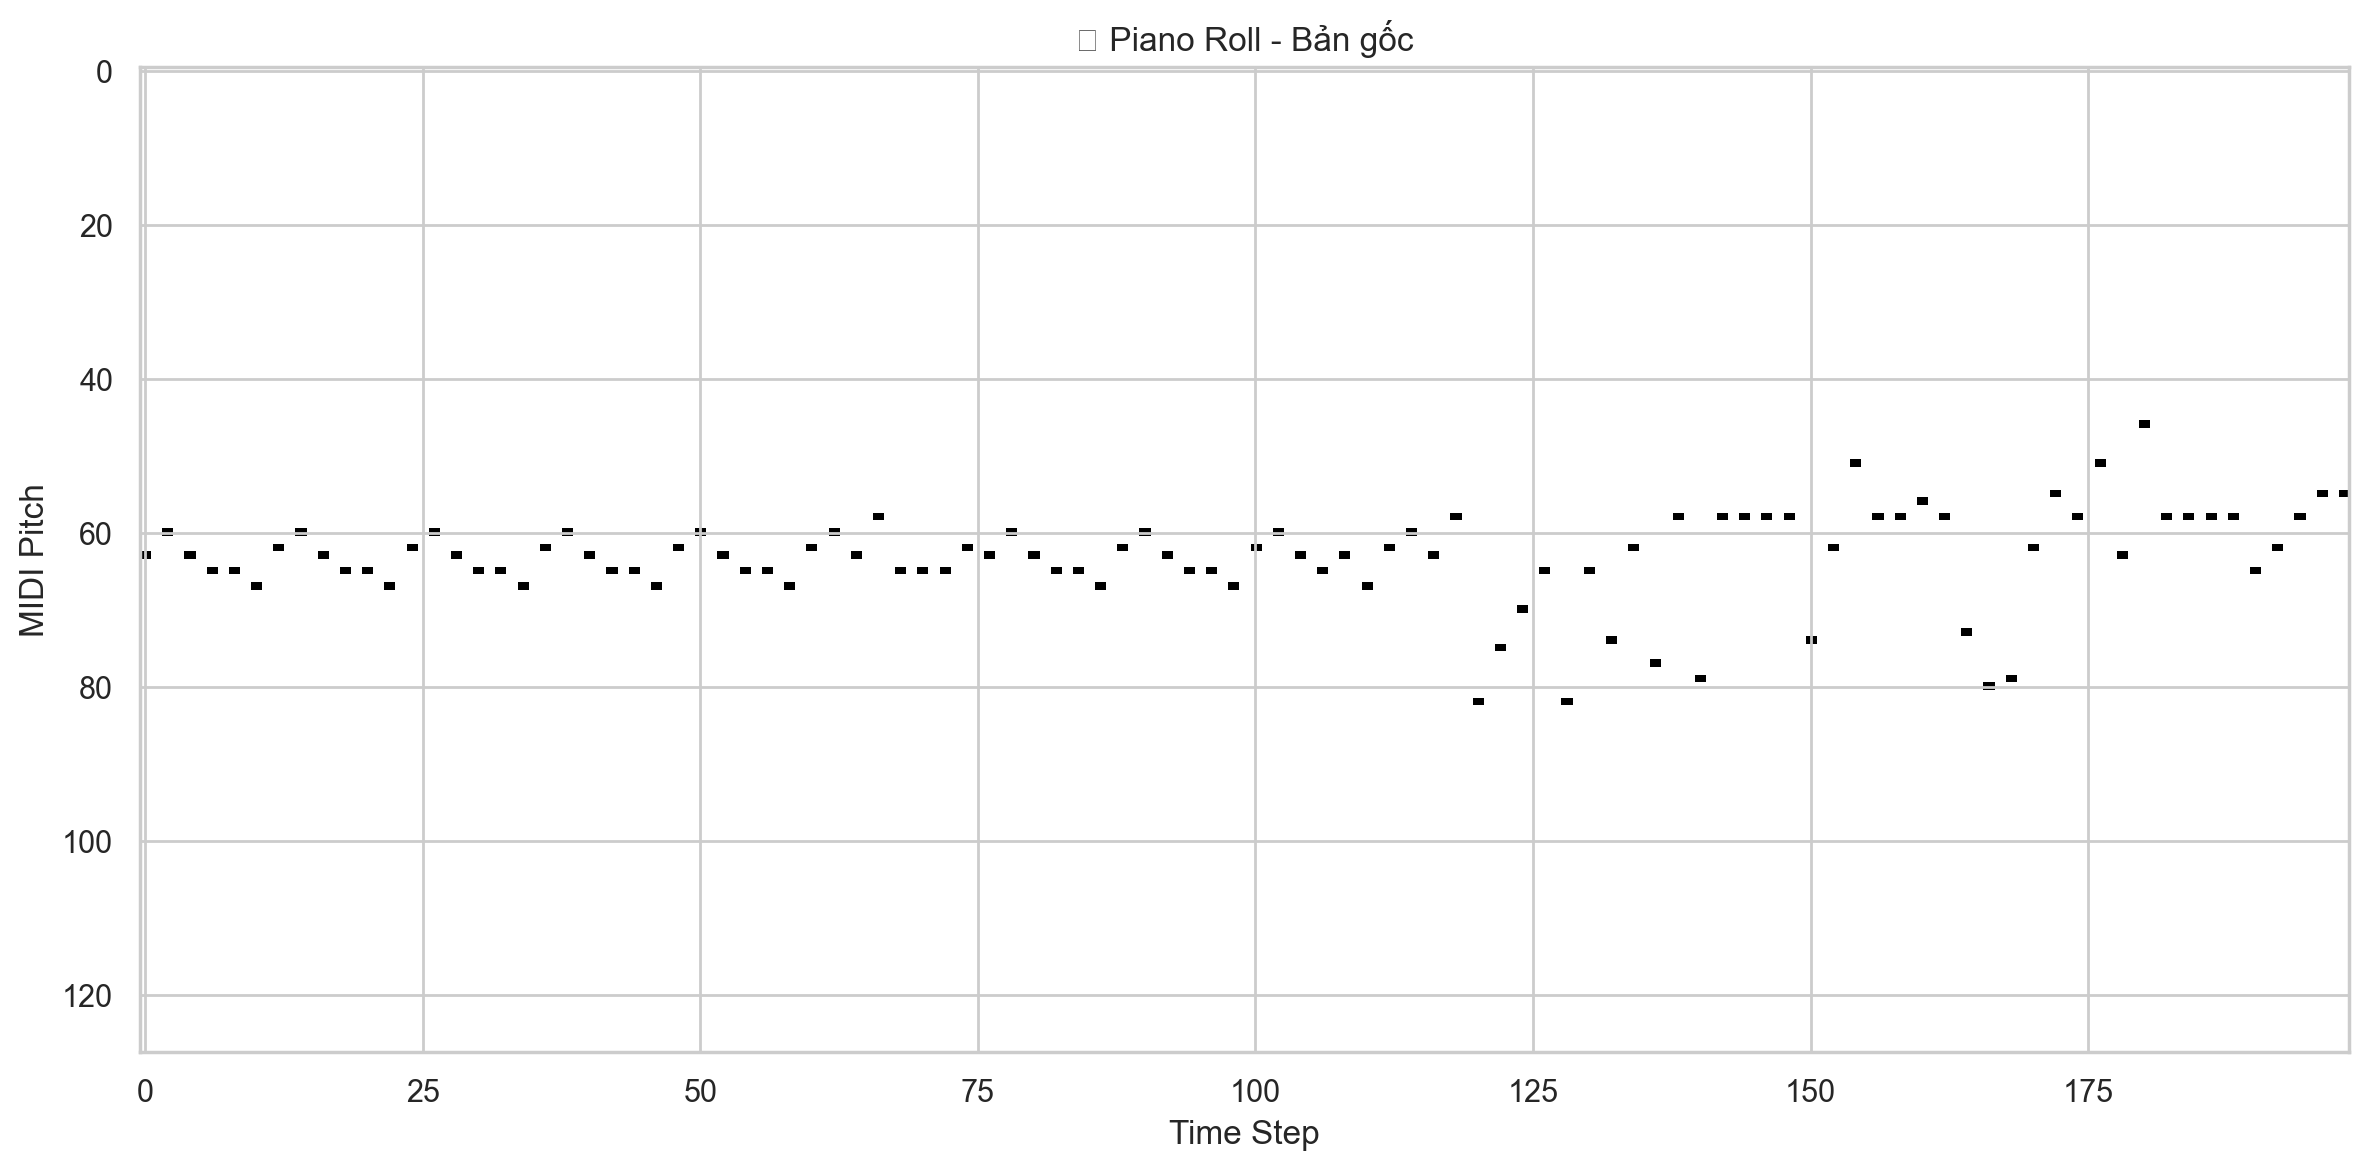

C:\Users\VuNgoc\AppData\Local\Temp\ipykernel_12192\3464485402.py:64: UserWarning: Glyph 127932 (\N{MUSICAL SCORE}) missing from font(s) Arial.
  plt.tight_layout()
d:\CĐE\myenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127932 (\N{MUSICAL SCORE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


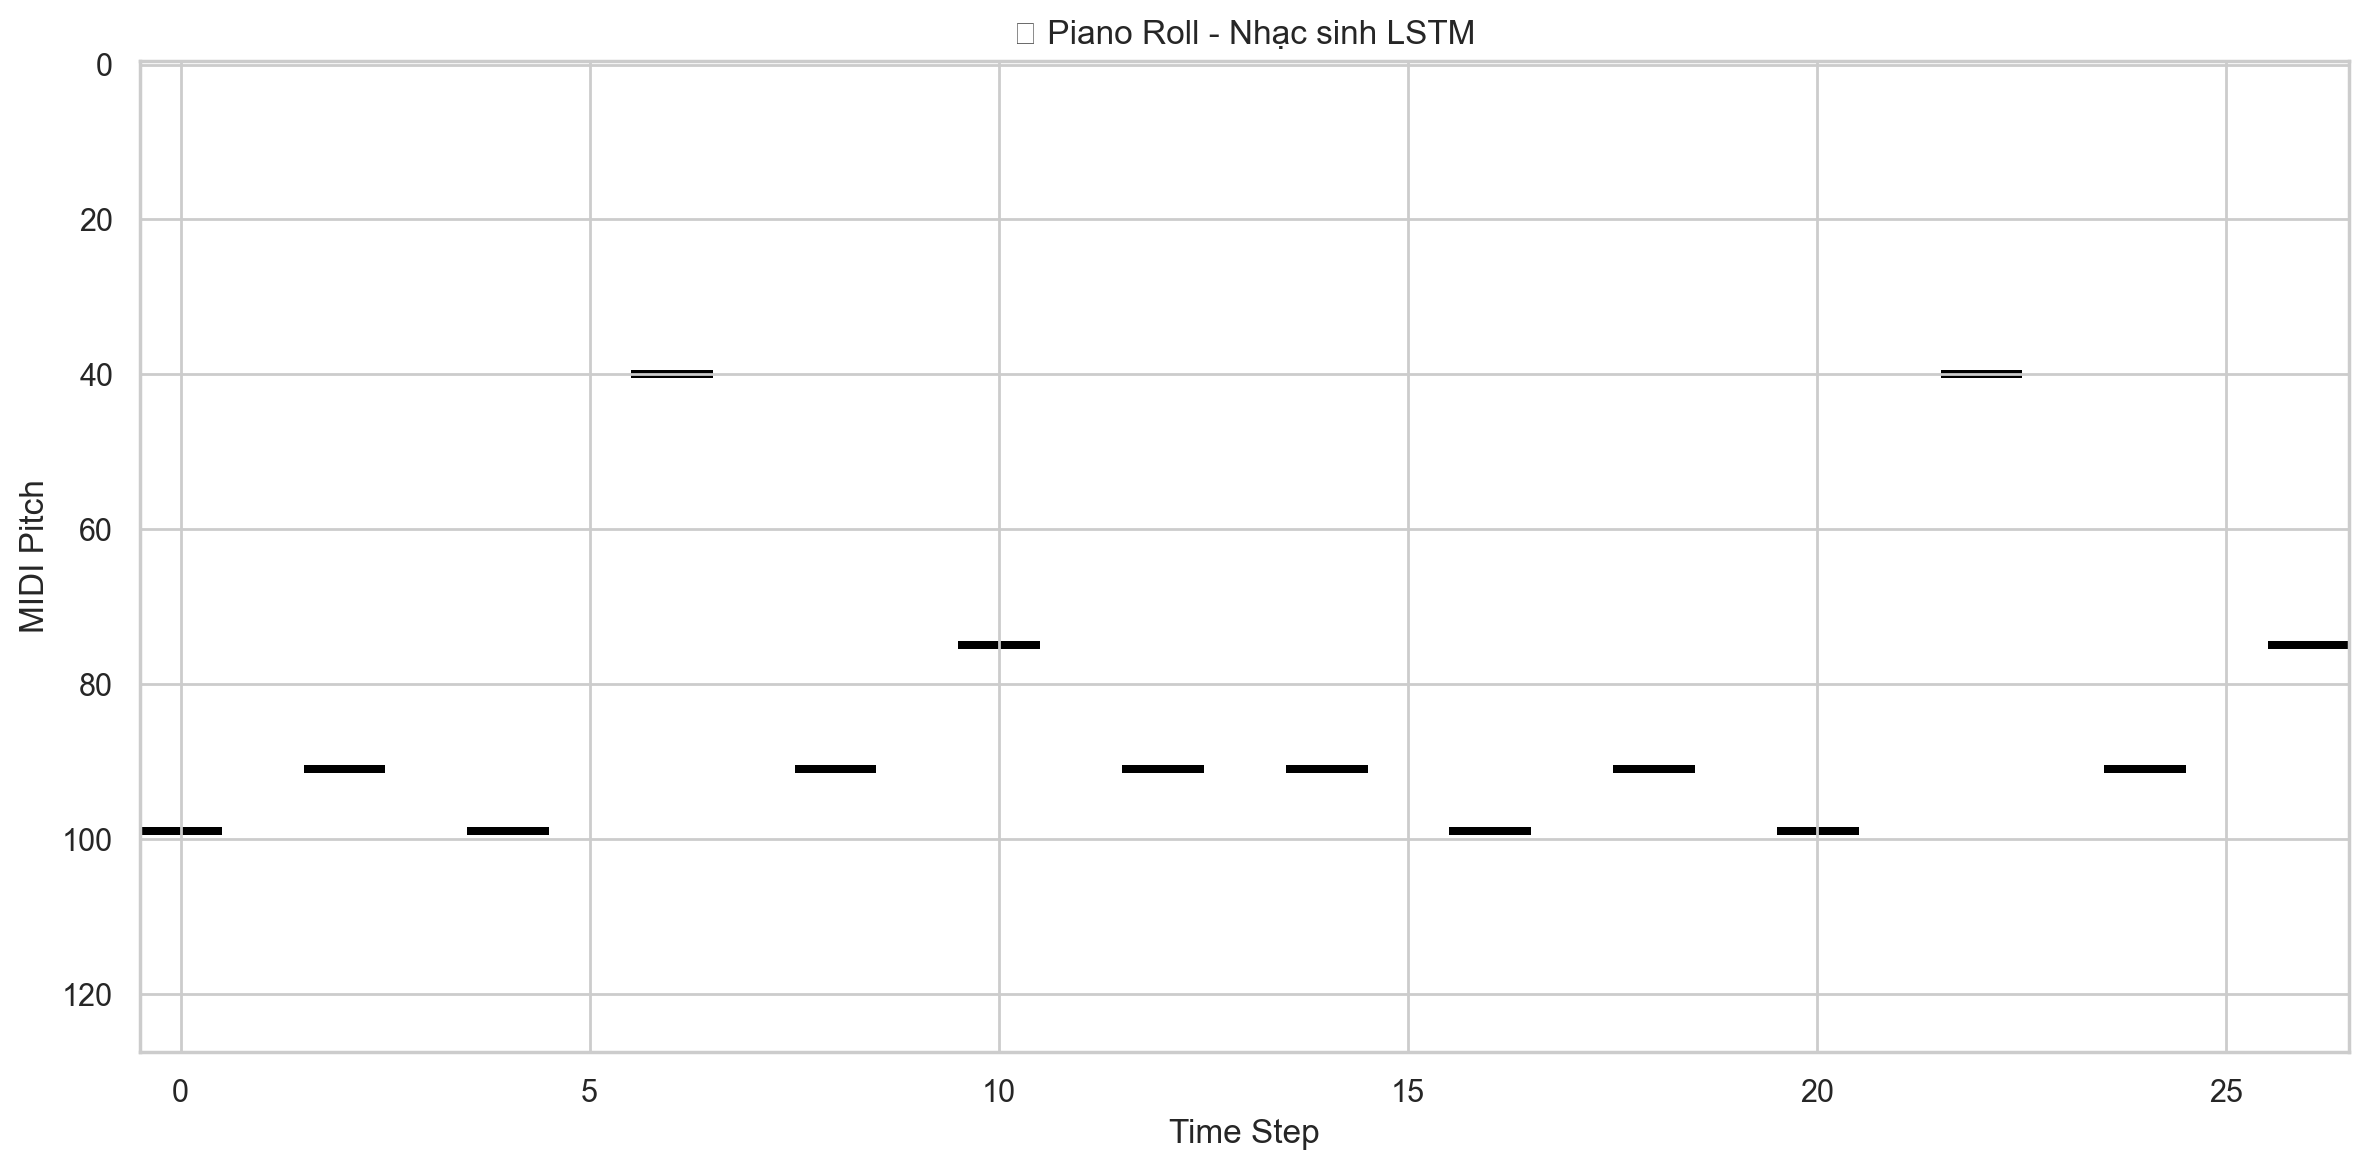

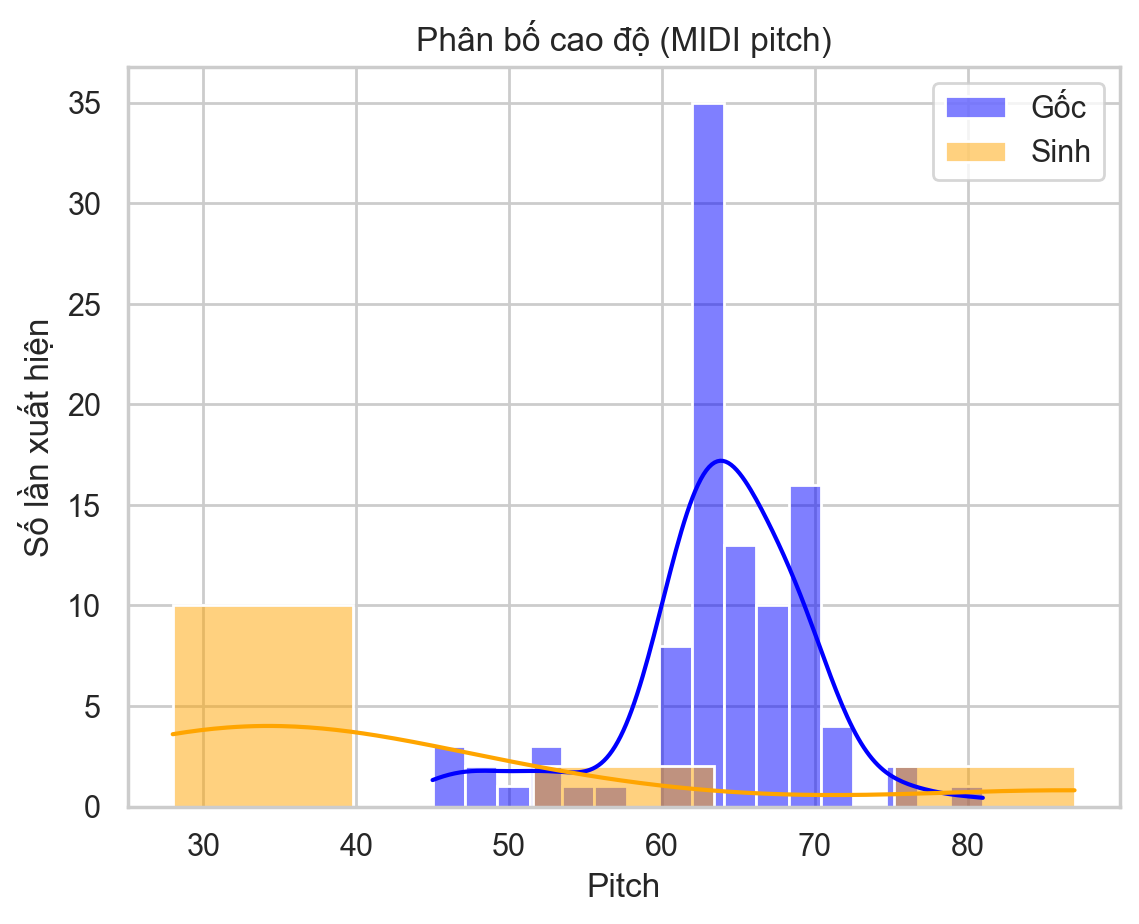

In [48]:
#So sánh MIDI mới vs cũ
def extract_note_stats(midi_path):
    midi = converter.parse(midi_path)

    parts = instrument.partitionByInstrument(midi)
    if parts:
        elements = parts.parts[0].recurse()
    else:
        elements = midi.flat.notes

    pitches = []
    offsets = []
    durations = []

    for element in elements:
        if isinstance(element, note.Note):
            pitches.append(element.pitch.midi)
            offsets.append(element.offset)
            durations.append(element.quarterLength)
        elif isinstance(element, chord.Chord):
            pitches.append(element.pitches[0].midi)
            offsets.append(element.offset)
            durations.append(element.quarterLength)

    return {
        "num_notes": len(pitches),
        "unique_pitches": len(set(pitches)),
        "avg_pitch": np.mean(pitches) if pitches else 0,
        "duration": max(offsets) + durations[-1] if offsets else 0,
        "pitches": pitches
    }

def build_piano_roll(note_events, time_resolution=0.25):
    if not note_events:
        return np.zeros((128, 1))
    max_time = max([offset for offset, pitch in note_events])
    num_steps = int(max_time / time_resolution) + 1
    piano_roll = np.zeros((128, num_steps))
    for offset, pitch in note_events:
        time_idx = int(offset / time_resolution)
        if 0 <= pitch < 128:
            piano_roll[pitch, time_idx] = 1
    return piano_roll

def extract_events(midi_path):
    midi = converter.parse(midi_path)
    parts = instrument.partitionByInstrument(midi)
    notes = parts.parts[0].recurse() if parts else midi.flat.notes

    events = []
    for element in notes:
        if isinstance(element, note.Note):
            events.append((element.offset, element.pitch.midi))
        elif isinstance(element, chord.Chord):
            events.append((element.offset, element.pitches[0].midi))
    return events

def plot_piano_roll(piano_roll, title):
    plt.figure(figsize=(12, 6))
    plt.imshow(piano_roll[::-1], aspect='auto', cmap='gray_r', interpolation='nearest')
    plt.title(title)
    plt.xlabel("Time Step")
    plt.ylabel("MIDI Pitch")
    plt.tight_layout()
    plt.show()

def compare_and_plot(real_path, generated_path):
    # So sánh đặc trưng
    real_stats = extract_note_stats(real_path)
    gen_stats = extract_note_stats(generated_path)

    print("🔎 So sánh thống kê giữa nhạc gốc và nhạc sinh:")
    print(f"Số lượng nốt:\t\t{real_stats['num_notes']} (gốc) vs {gen_stats['num_notes']} (sinh)")
    print(f"Cao độ trung bình:\t{real_stats['avg_pitch']:.2f} (gốc) vs {gen_stats['avg_pitch']:.2f} (sinh)")
    print(f"Độ dài bài hát:\t\t{real_stats['duration']:.2f} s (gốc) vs {gen_stats['duration']:.2f} s (sinh)")
    print(f"Số cao độ khác nhau:\t{real_stats['unique_pitches']} (gốc) vs {gen_stats['unique_pitches']} (sinh)")

    # Piano roll
    real_events = extract_events(real_path)
    gen_events = extract_events(generated_path)

    real_roll = build_piano_roll(real_events)
    gen_roll = build_piano_roll(gen_events)

    plot_piano_roll(real_roll, "🎵 Piano Roll - Bản gốc")
    plot_piano_roll(gen_roll, "🎼 Piano Roll - Nhạc sinh LSTM")

    # Biểu đồ phân bố cao độ
    sns.histplot(real_stats["pitches"], color="blue", label="Gốc", kde=True)
    sns.histplot(gen_stats["pitches"], color="orange", label="Sinh", kde=True)
    plt.title("Phân bố cao độ (MIDI pitch)")
    plt.xlabel("Pitch")
    plt.ylabel("Số lần xuất hiện")
    plt.legend()
    plt.show()


# 👉 Dùng hàm so sánh
compare_and_plot(
    real_path="D:/CĐE/test/generated_music_lstm.mid",
    generated_path="D:/CĐE/test/generated_music_lstm_2.mid"
)


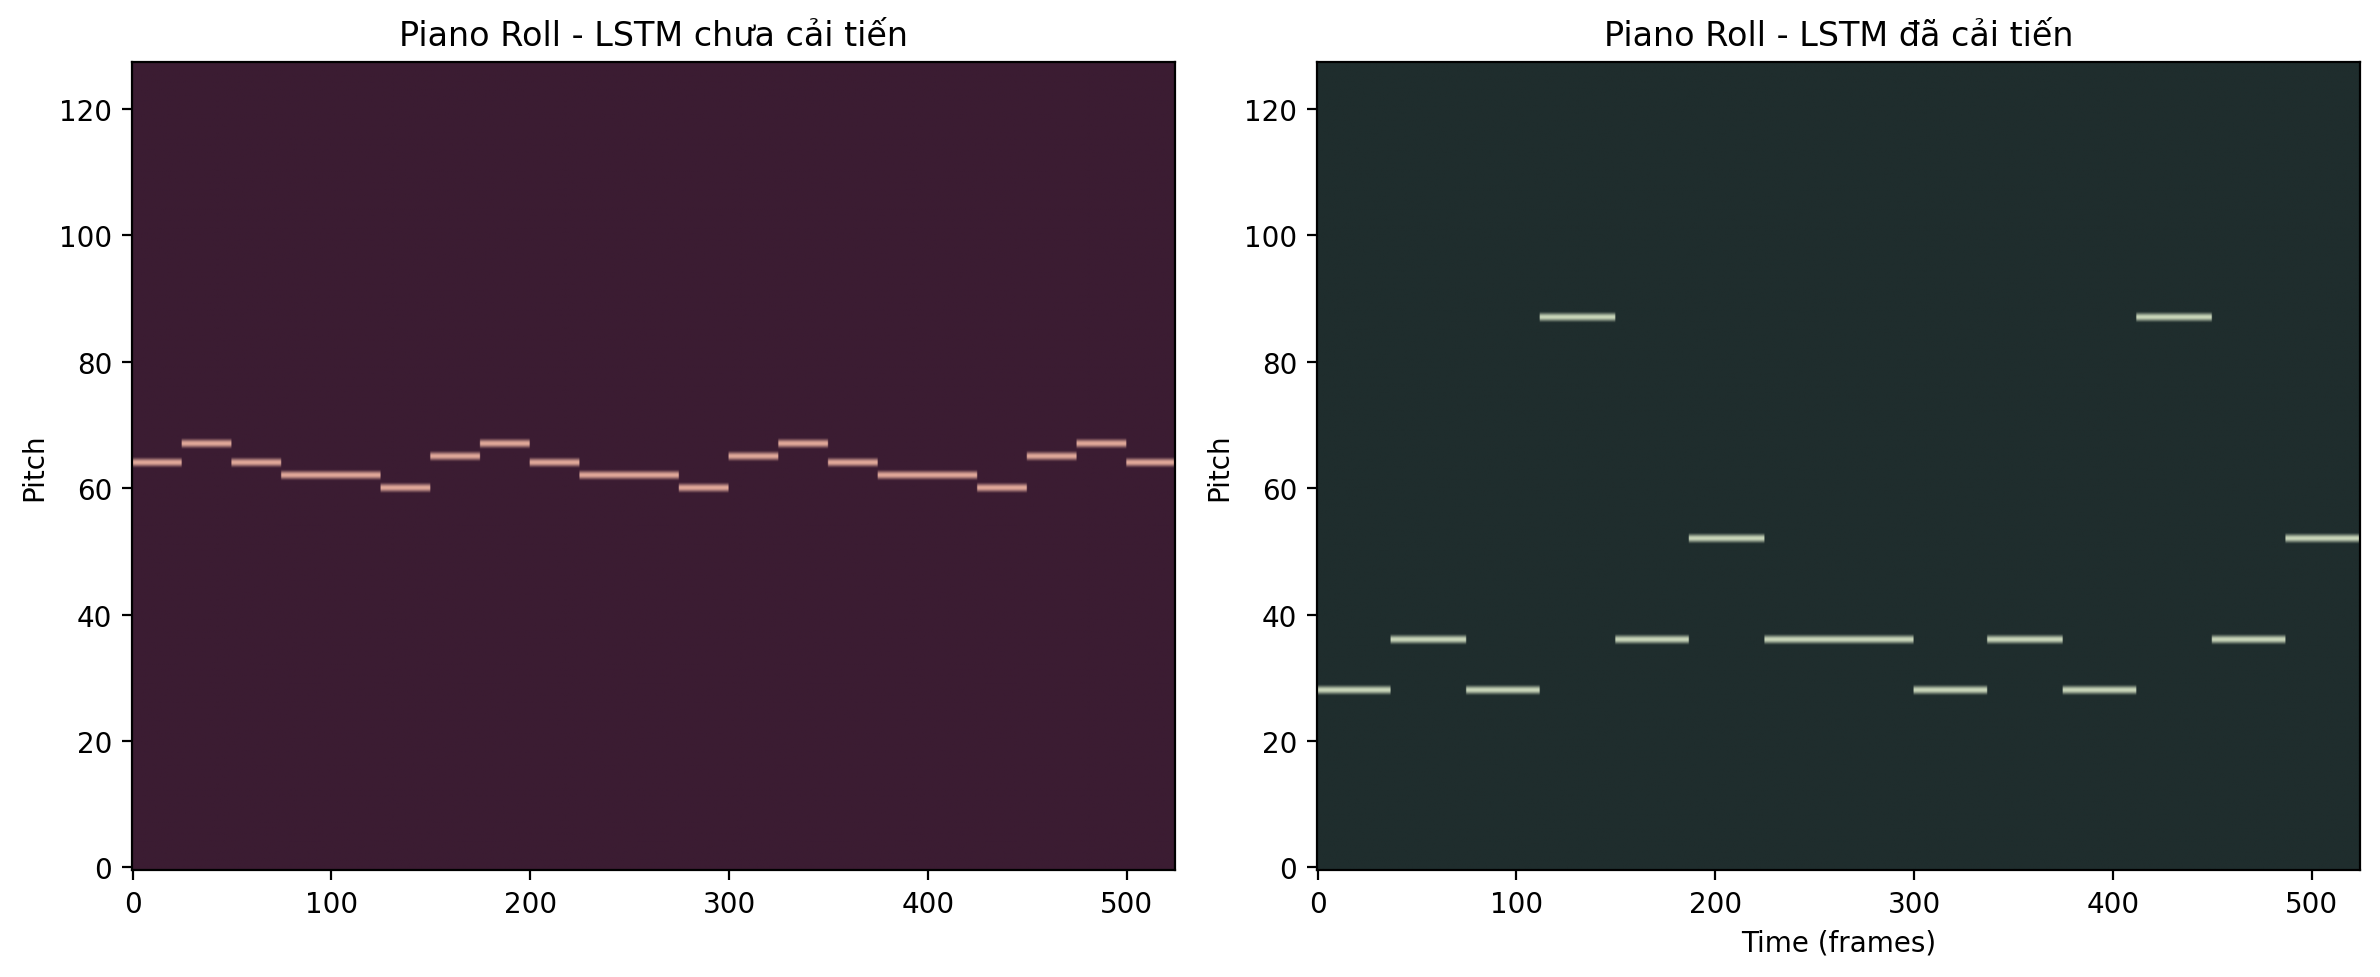

In [12]:
from matplotlib.colors import LinearSegmentedColormap

# Tạo colormap nhẹ nhàng
ts_color_1 = LinearSegmentedColormap.from_list("trinh_color_1", ["#3b1c32", "#a26769", "#e0a899"])
ts_color_2 = LinearSegmentedColormap.from_list("trinh_color_2", ["#1f2d2d", "#4a7c59", "#c8d5b9"])

# Vẽ piano roll
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

axs[0].imshow(piano_roll_1, aspect='auto', origin='lower', cmap=ts_color_1)
axs[0].set_title("Piano Roll - LSTM chưa cải tiến", fontsize=12)
axs[0].set_ylabel("Pitch")

axs[1].imshow(piano_roll_2, aspect='auto', origin='lower', cmap=ts_color_2)
axs[1].set_title("Piano Roll - LSTM đã cải tiến", fontsize=12)
axs[1].set_xlabel("Time (frames)")
axs[1].set_ylabel("Pitch")

plt.tight_layout()
plt.show()


MÔ HÌNH VAE


In [18]:
# Tải dữ liệu MIDI đã xử lý
with open("D:/CĐE/test/midi_data_music21.pkl", "rb") as f:
    loaded_data = pickle.load(f)

# Tạo mapping giữa nốt nhạc và số nguyên
all_notes = sorted(set(note["pitch"] for song in loaded_data for note in song))
note_to_int = {note: i + 1 for i, note in enumerate(all_notes)}
int_to_note = {i + 1: note for i, note in enumerate(all_notes)}
num_notes = len(note_to_int) + 1  # +1 để tránh lỗi mapping

# Chuẩn bị dữ liệu đầu vào
seq_length = 100  # Độ dài mỗi chuỗi đầu vào
X = []

for song in loaded_data:
    notes = np.array([note_to_int.get(note["pitch"], 0) for note in song])
    for i in range(len(notes) - seq_length):
        X.append(notes[i:i + seq_length])

X = np.array(X).reshape(len(X), seq_length, 1)  # Định dạng lại thành (samples, time steps, features)

# Chia dữ liệu thành tập huấn luyện và kiểm tra
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]

print(f"Size of training data: {X_train.shape}")
print(f"Size of test data: {X_test.shape}")

Size of training data: (19777, 100, 1)
Size of test data: (4945, 100, 1)


In [45]:
latent_dim = 16  # Kích thước không gian tiềm ẩn

# ENCODER
inputs = Input(shape=(seq_length, 1))
x = LSTM(128, return_sequences=True)(inputs)
x = LSTM(64, return_sequences=False)(x)
z_mean = Dense(latent_dim, name="z_mean")(x)
z_log_var = Dense(latent_dim, name="z_log_var")(x)

# Hàm sampling từ phân phối Gaussian
def sampling(args):
    z_mean, z_log_var = args
    batch_size = tf.shape(z_mean)[0]
    epsilon = tf.random.normal(shape=(batch_size, latent_dim), mean=0.0, stddev=1.0)
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,), name="z")([z_mean, z_log_var])

# DECODER
decoder_input = Input(shape=(latent_dim,))
x = RepeatVector(seq_length)(decoder_input)
x = LSTM(64, return_sequences=True)(x)
x = LSTM(128, return_sequences=True)(x)
outputs = TimeDistributed(Dense(num_notes, activation="softmax"))(x)

# Mô hình encoder và decoder
encoder = Model(inputs, [z_mean, z_log_var, z], name="Encoder")
decoder = Model(decoder_input, outputs, name="Decoder")

vae_outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, vae_outputs, name="VAE")

# Hàm KL loss
def vae_kl_loss(z_mean, z_log_var):
    kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
    return kl_loss

class KLLossLayer(Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        kl_loss = tf.reduce_mean(vae_kl_loss(z_mean, z_log_var))
        self.add_loss(kl_loss)  # Thêm loss trực tiếp trong Layer
        return inputs  # Trả lại đầu vào không thay đổi

kl_loss_layer = KLLossLayer()([z_mean, z_log_var])
vae.compile(optimizer=tf.keras.optimizers.Adam(), loss="sparse_categorical_crossentropy")
# Huấn luyện mô hình VAE
history_vae = vae.fit(X_train, X_train, epochs=50, batch_size=64, validation_data=(X_test, X_test))
# Lưu mô hình đã huấn luyện
vae.save("D:/CĐE/test/music_vae.h5")
encoder.save("D:/CĐE/test/music_encoder.h5")
decoder.save("D:/CĐE/test/music_decoder.h5")

print("Mô hình đã được huấn luyện và lưu.")

Epoch 1/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 155s 454ms/step - loss: 3.6157 - val_loss: 3.8780
Epoch 2/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 146s 470ms/step - loss: 3.4939 - val_loss: 3.8528
Epoch 3/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 152s 491ms/step - loss: 3.4382 - val_loss: 3.8379
Epoch 4/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 184s 433ms/step - loss: 3.4024 - val_loss: 4.0832
Epoch 5/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 138s 444ms/step - loss: 3.4995 - val_loss: 3.9072
Epoch 6/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 141s 442ms/step - loss: 3.3105 - val_loss: 3.7036
Epoch 7/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 137s 443ms/step - loss: 3.2163 - val_loss: 3.8277
Epoch 8/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 146s 470ms/step - loss: 3.1364 - val_loss: 3.9623
Epoch 9/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 140s 451ms/step - loss: 3.0764 - val_loss: 4.1649
Epoch 10/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 136s 440ms/step - loss: 3.2301 - val_loss: 3.7730
Epoch 11/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 136s 439ms/step - loss: 3.0355 - val_loss: 3.9018
Epoch 12

Mô hình đã được huấn luyện và lưu.


In [46]:
# Hàm sinh nhạc từ latent vector
def generate_music_from_latent(decoder, latent_vector, num_notes=80):
    generated_notes = decoder.predict(latent_vector)
    generated_notes = np.argmax(generated_notes, axis=-1)  # Chuyển thành chỉ số nốt nhạc
    return generated_notes.flatten()[:num_notes]  # Trả về 80 nốt nhạc

# Tạo latent vector từ encoder
sample_song = np.expand_dims(X_train[0], axis=0)  # Chọn một chuỗi nhạc đầu vào từ tập huấn luyện
latent_vector = encoder.predict(sample_song)[2]  # Lấy latent vector từ encoder

# Sinh nhạc từ latent vector
generated_notes = generate_music_from_latent(decoder, latent_vector)

# Ánh xạ chỉ số nốt nhạc sang tên nốt nhạc
note_mapping = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
def map_to_notes(indices):
    return [note_mapping[int(i) % len(note_mapping)] for i in np.array(indices).flatten()]

# Ánh xạ nốt nhạc sinh ra
mapped_notes = map_to_notes(generated_notes)

# Giới hạn thang âm Trịnh Công Sơn
trinh_scale = ["C", "D", "E", "G", "A", "Bb", "F"]
def generate_trinh_music(mapped_notes):
    processed_notes = []
    for note in mapped_notes:
        if note not in trinh_scale:
            note = np.random.choice(trinh_scale)  # Điều chỉnh về thang âm Trịnh
        processed_notes.append(note)
    return processed_notes

# Sinh nhạc theo phong cách Trịnh Công Sơn
trinh_music_notes = generate_trinh_music(mapped_notes)

# Tạo file MIDI từ nhạc đã sinh ra
import music21

midi_stream = music21.stream.Stream()
midi_stream.append(music21.tempo.MetronomeMark(number=90))  # Tempo 90 BPM

# Chọn thời gian cho từng nốt nhạc
total_duration = 0
for note_name in trinh_music_notes:
    n = music21.note.Note(note_name)
    duration = np.random.choice([0.5, 1, 1.5], p=[0.4, 0.4, 0.2])  # Nốt dài 0.5s, 1s hoặc 1.5s
    n.quarterLength = duration
    midi_stream.append(n)
    total_duration += duration * (60 / 90)  # Tính toán thời gian tổng
    if total_duration >= 25:  # Dừng khi đạt 25s
        break

# Xuất ra file MIDI
output_midi = "D:/CĐE/test/generated_trinh_music_vae.mid"
midi_stream.write("midi", fp=output_midi)

print(f"Nhạc Trịnh đã được tạo và lưu tại {output_midi}! Thời gian ước tính: {round(total_duration, 2)}s")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Nhạc Trịnh đã được tạo và lưu tại D:/CĐE/test/generated_trinh_music_vae.mid! Thời gian ước tính: 25.67s


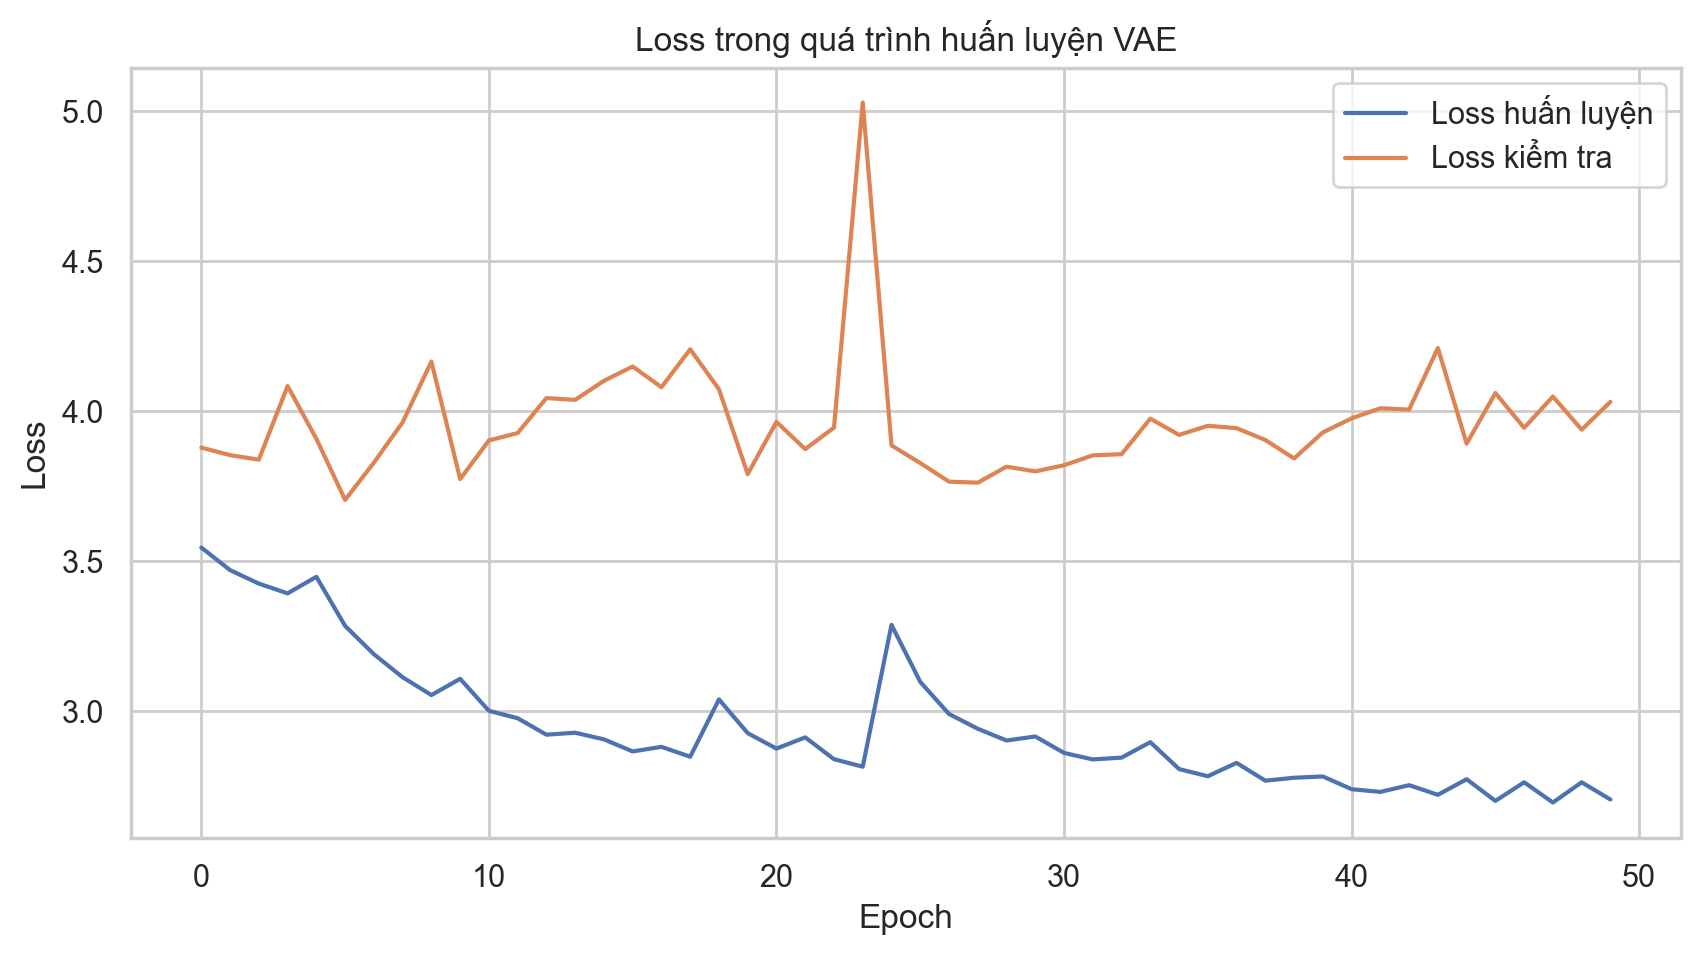

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history_vae.history['loss'], label='Loss huấn luyện')
plt.plot(history_vae.history['val_loss'], label='Loss kiểm tra')
plt.title('Loss trong quá trình huấn luyện VAE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [19]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Lấy 1000 sample từ tập huấn luyện để trực quan hóa
sample_data = X_train[:1000]
z_mean_vals = encoder.predict(sample_data)[0]  # z_mean được dùng để biểu diễn không gian tiềm ẩn

print(f"Shape of latent vectors: {z_mean_vals.shape}")


NameError: name 'encoder' is not defined

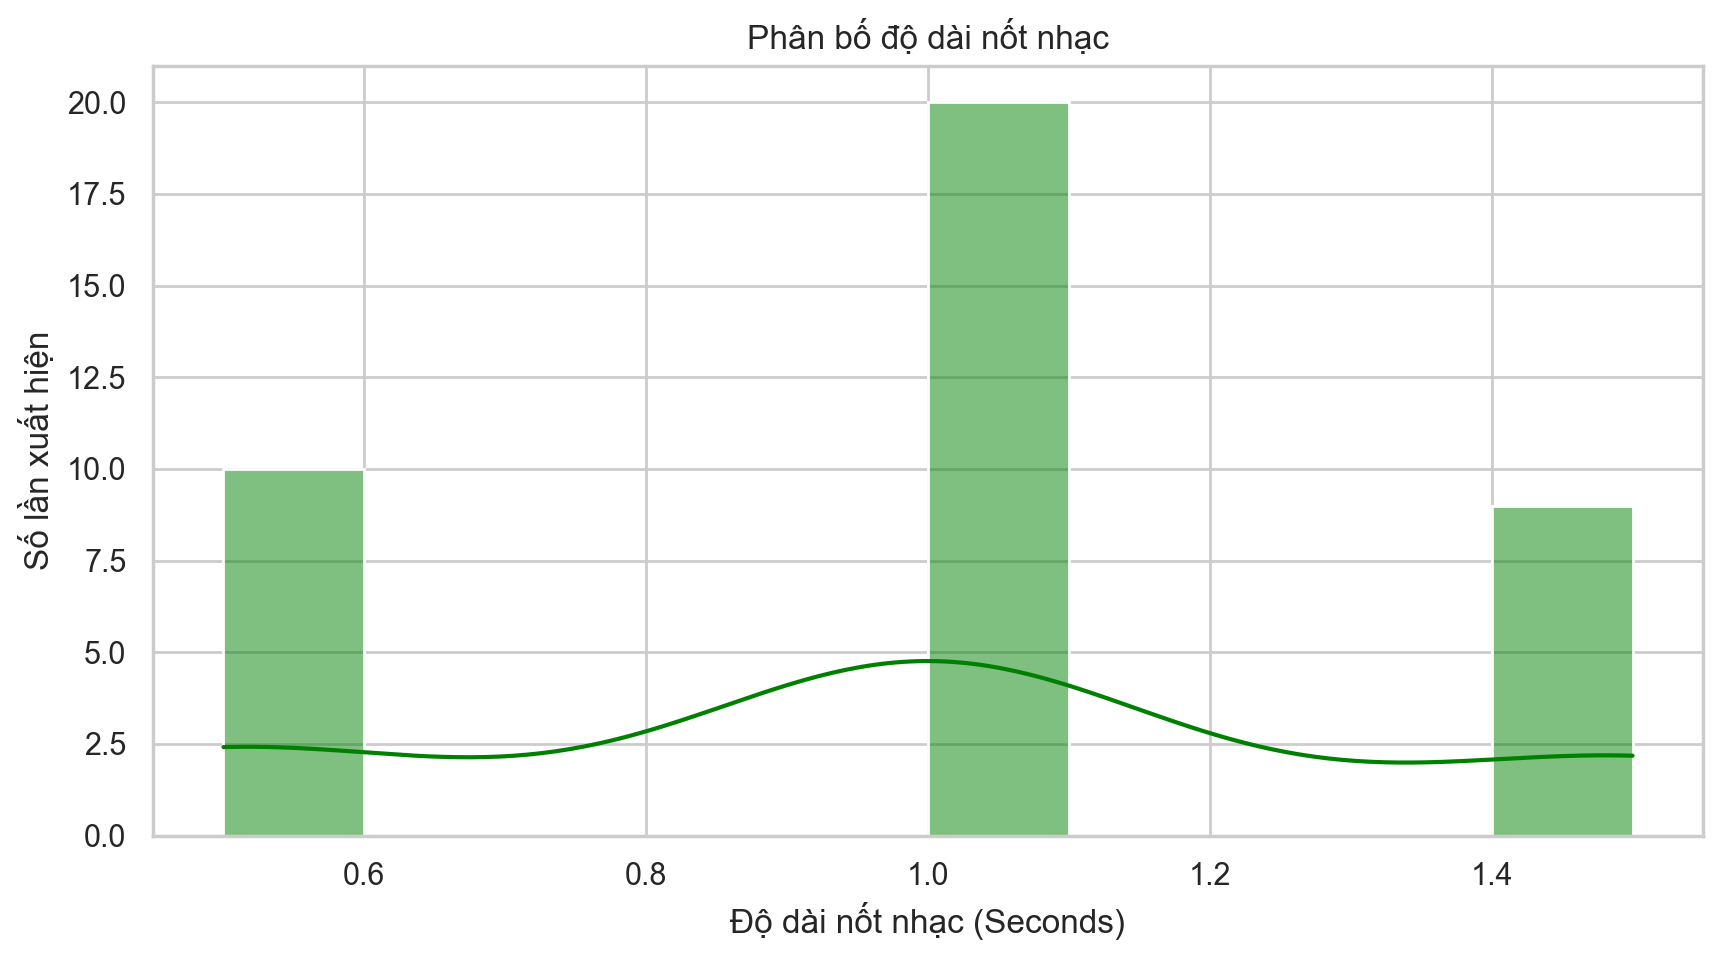

In [55]:
# Vẽ biểu đồ phân bố độ dài nốt nhạc (Duration Distribution)
durations = [n.quarterLength for n in midi_stream.notes]  # Lấy độ dài nốt từ file MIDI
plt.figure(figsize=(10, 5))
sns.histplot(durations, bins=10, kde=True, color="green")
plt.xlabel("Độ dài nốt nhạc (Seconds)")
plt.ylabel("Số lần xuất hiện")
plt.title("Phân bố độ dài nốt nhạc")
plt.show()

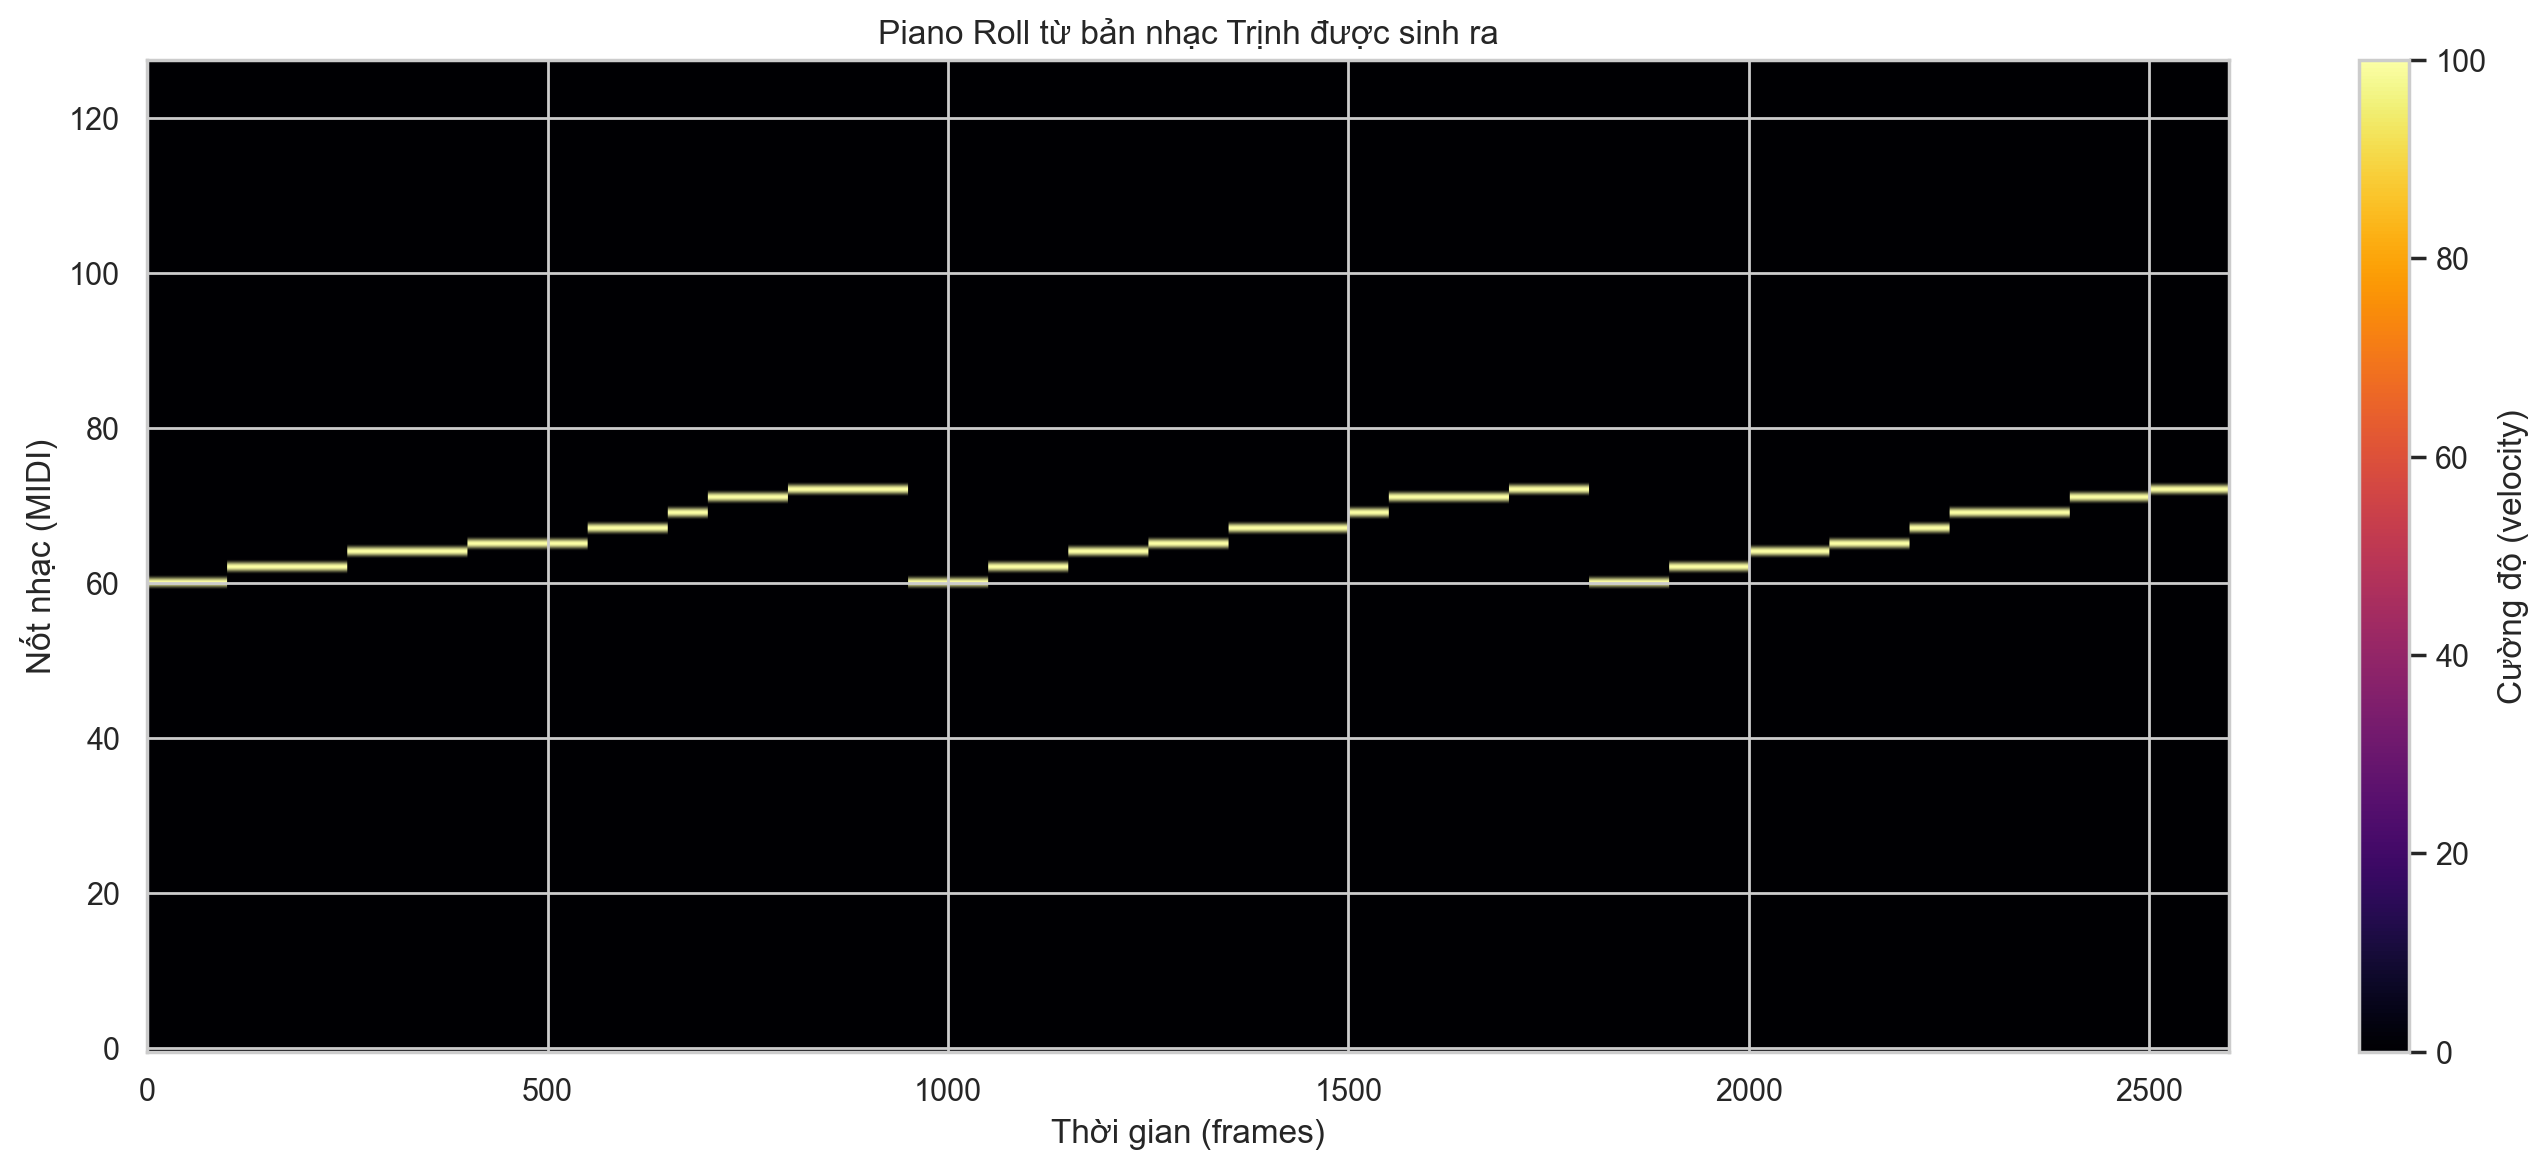

In [58]:
import pretty_midi
import numpy as np
import matplotlib.pyplot as plt

def generate_piano_roll(note_list, output_path="piano_roll.png"):
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=0)  # Acoustic Grand Piano

    start = 0.0
    for n in note_list:
        try:
            midi_number = pretty_midi.note_name_to_number(n)
            duration = np.random.choice([0.5, 1.0, 1.5], p=[0.4, 0.4, 0.2])
            note_obj = pretty_midi.Note(velocity=100, pitch=midi_number,
                                        start=start, end=start + duration)
            instrument.notes.append(note_obj)
            start += duration
        except:
            continue  # Bỏ qua nếu tên nốt không hợp lệ

    pm.instruments.append(instrument)

    # Vẽ piano roll
    piano_roll = pm.get_piano_roll(fs=100)
    plt.figure(figsize=(14, 6))
    plt.imshow(piano_roll, aspect='auto', origin='lower', cmap='inferno')
    plt.title("Piano Roll từ bản nhạc Trịnh được sinh ra")
    plt.xlabel("Thời gian (frames)")
    plt.ylabel("Nốt nhạc (MIDI)")
    plt.colorbar(label="Cường độ (velocity)")
    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()

# Gọi hàm với danh sách nốt bạn đã sinh
trinh_notes = ['C4', 'D4', 'E4', 'F4', 'G4', 'A4', 'B4', 'C5'] * 3

generate_piano_roll(trinh_notes)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


C:\Users\VuNgoc\AppData\Local\Temp\ipykernel_12192\3728999955.py:42: UserWarning: Glyph 127932 (\N{MUSICAL SCORE}) missing from font(s) Arial.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
C:\Users\VuNgoc\AppData\Local\Temp\ipykernel_12192\3728999955.py:42: UserWarning: Glyph 127929 (\N{MUSICAL KEYBOARD}) missing from font(s) Arial.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
C:\Users\VuNgoc\AppData\Local\Temp\ipykernel_12192\3728999955.py:42: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
C:\Users\VuNgoc\AppData\Local\Temp\ipykernel_12192\3728999955.py:43: UserWarning: Glyph 127932 (\N{MUSICAL SCORE}) missing from font(s) Arial.
  plt.savefig("vae_piano_roll_comparison.png", dpi=300)
C:\Users\VuNgoc\AppData\Local\Temp\ipykernel_12192\3728999955.py:43: UserWarning: Glyph 127929 (\N{MUSICAL KEYBOARD}) missing from font(s) Arial.
  plt.savefig("vae_piano_roll_comparison.png", dpi=300)
C:\Users\VuNgoc\AppData\Loc

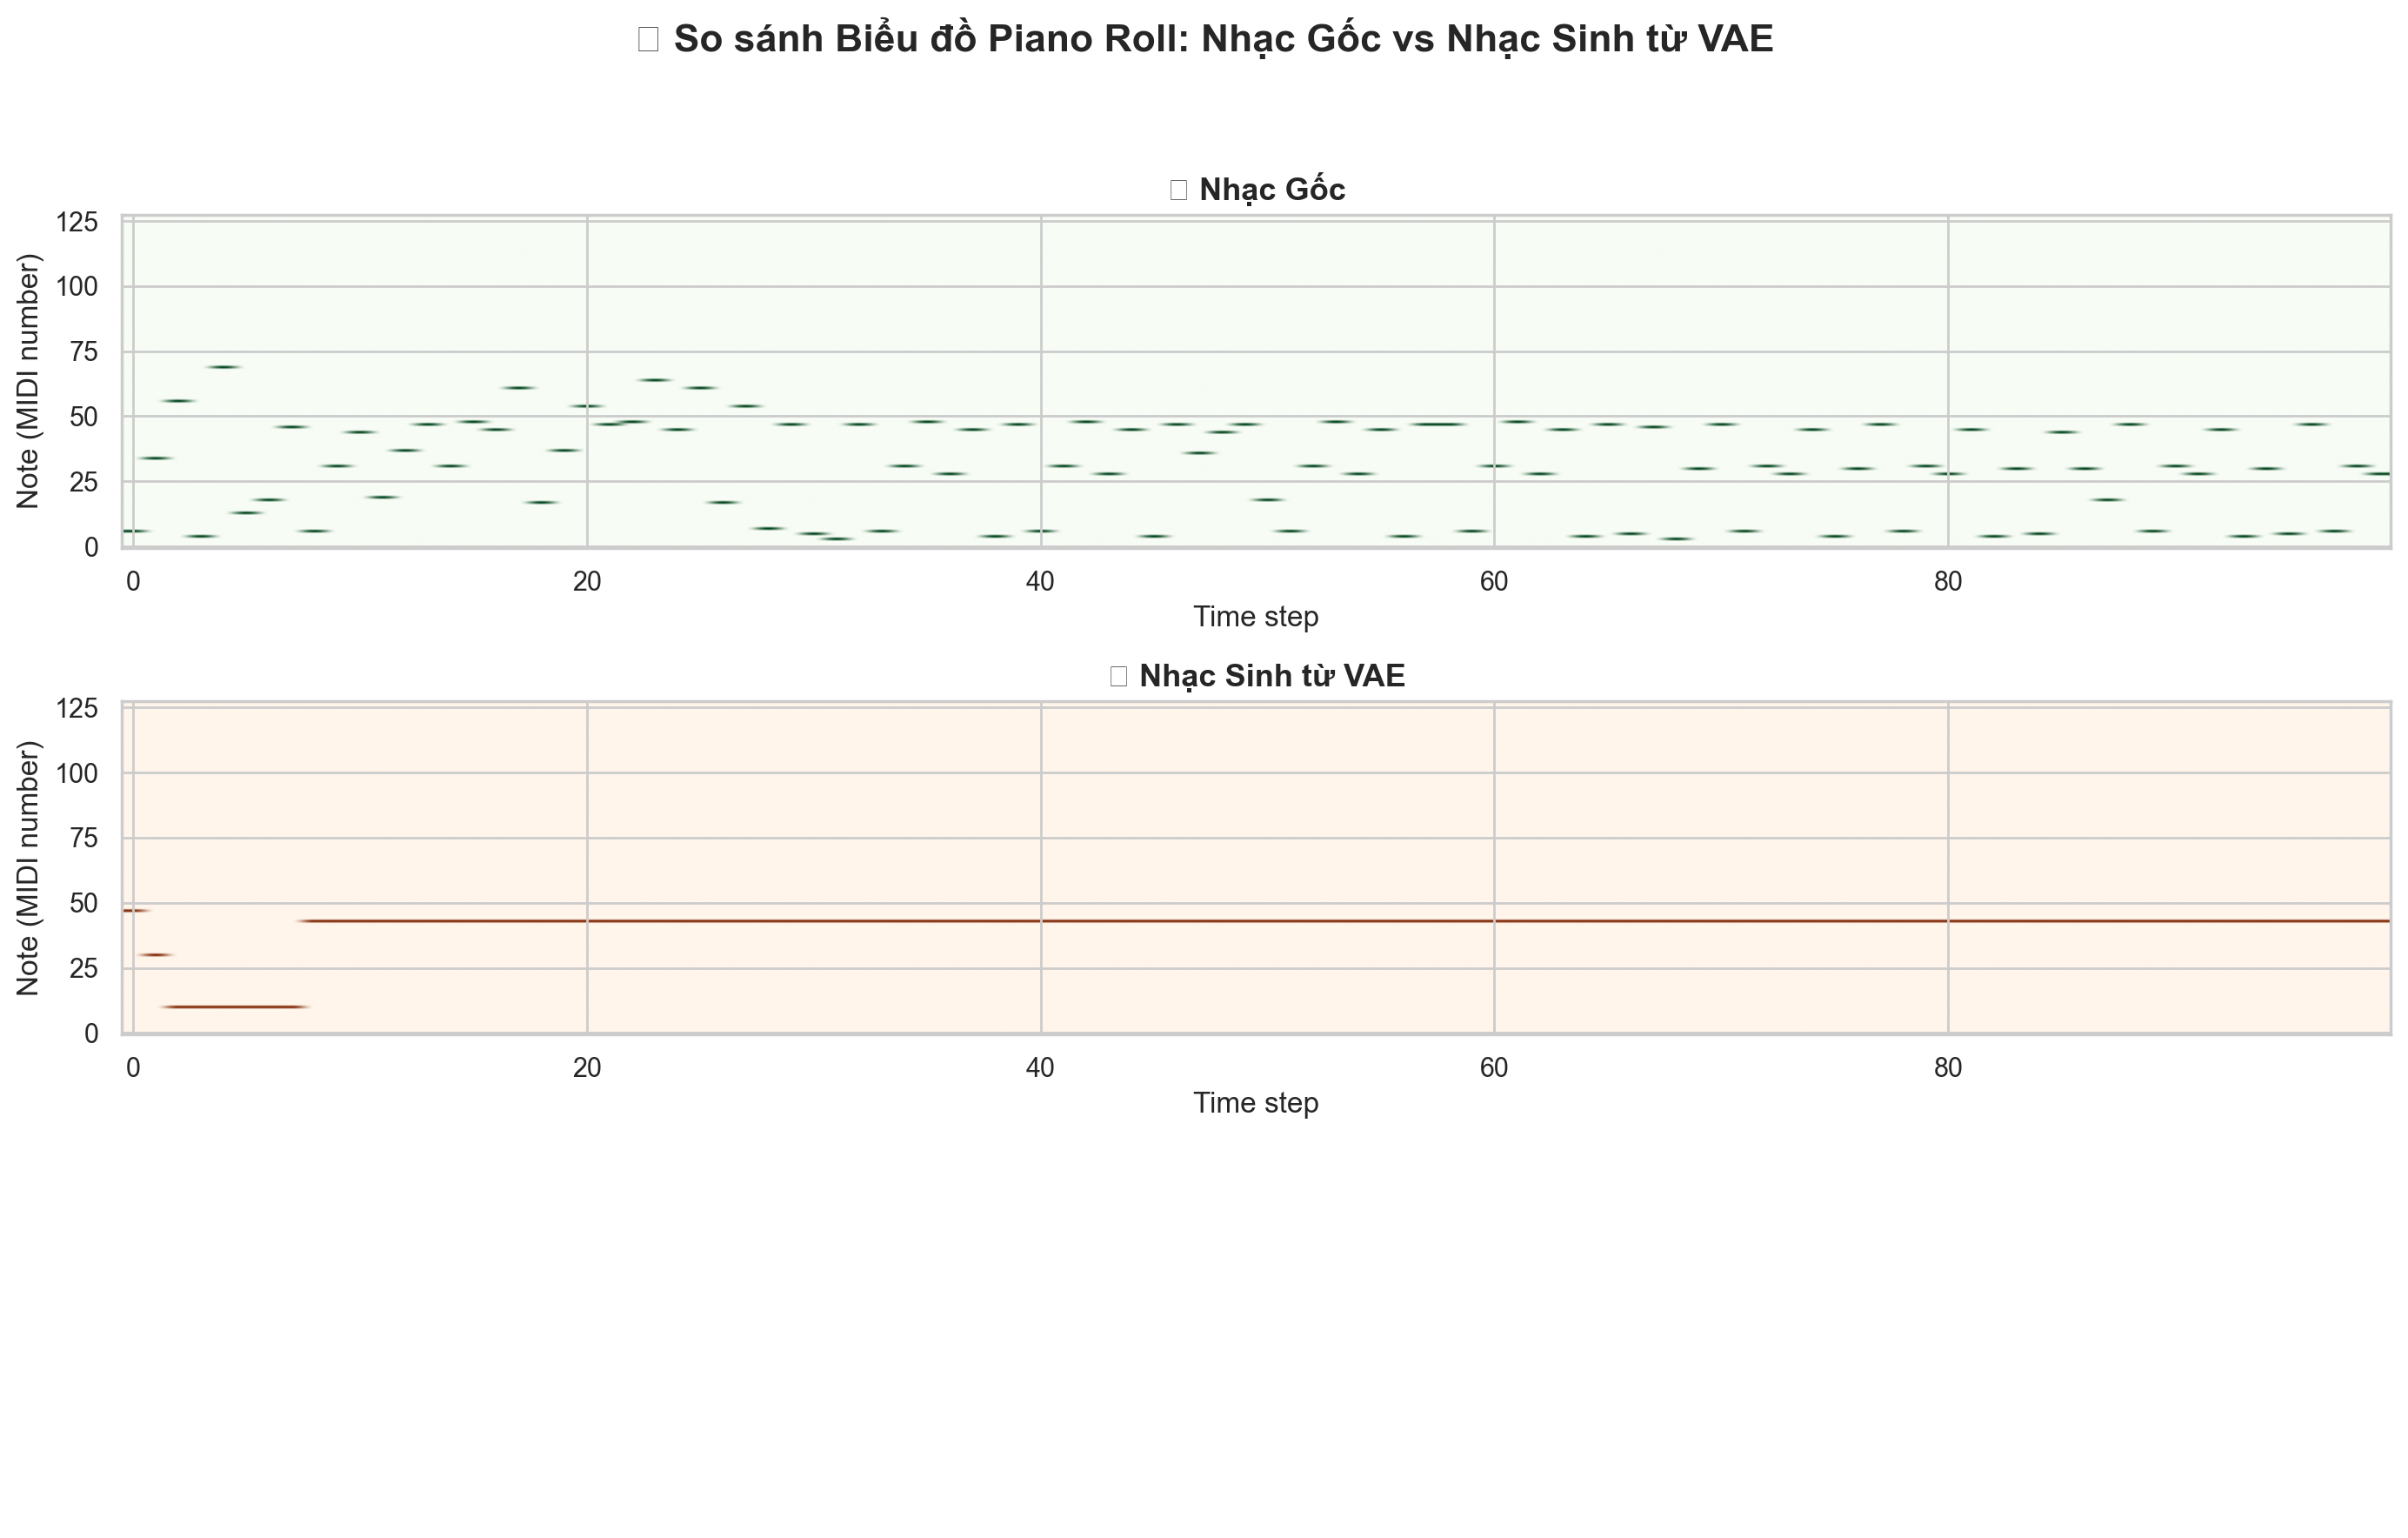

In [65]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def plot_piano_roll(note_sequence, title, ax, cmap="Blues", num_notes=128):
    """
    Vẽ piano roll từ chuỗi nốt (dạng chỉ số nốt).
    """
    seq_length = len(note_sequence)
    piano_roll = np.zeros((num_notes, seq_length))
    for t, note in enumerate(note_sequence):
        if 0 < note < num_notes:
            piano_roll[note, t] = 1
    ax.imshow(piano_roll, aspect='auto', origin='lower', cmap=cmap)
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.set_ylabel("Note (MIDI number)")
    ax.set_xlabel("Time step")

# Giả sử bạn đã có dữ liệu:
# - `X_test` là tập kiểm tra đầu vào của mô hình
# - `decoder` là decoder từ VAE
# - `latent_dim` là số chiều không gian tiềm ẩn

# Vẽ biểu đồ
fig, axs = plt.subplots(3, 1, figsize=(14, 9))

# Nhạc gốc
original_seq = X_test[0].squeeze()
plot_piano_roll(original_seq, "🎼 Nhạc Gốc", axs[0], cmap="Greens")

# Nhạc sinh từ VAE
z_sample = tf.random.normal(shape=(1, latent_dim))
vae_probs = decoder.predict(z_sample)
vae_seq = np.argmax(vae_probs, axis=-1)[0]
plot_piano_roll(vae_seq, "🎹 Nhạc Sinh từ VAE", axs[1], cmap="Oranges")

# (Nếu bạn có thể thêm một mô hình khác, ví dụ LSTM hay Transformer thì có thể vẽ ở dòng thứ 3)
axs[2].axis("off")  # Ẩn biểu đồ thứ 3 nếu chưa dùng

# Tiêu đề chung
fig.suptitle("🔍 So sánh Biểu đồ Piano Roll: Nhạc Gốc vs Nhạc Sinh từ VAE", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("vae_piano_roll_comparison.png", dpi=300)
plt.show()



Transformer

In [ ]:
# Transformer Block 
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
class TransformerMusicModel(Model):
    def __init__(self, num_notes, embed_dim=128, num_heads=4, ff_dim=512, num_layers=4, seq_length=50):
        super(TransformerMusicModel, self).__init__()
        self.embedding = Embedding(input_dim=num_notes, output_dim=embed_dim)
        self.pos_encoding = self.positional_encoding(seq_length, embed_dim)
        self.transformer_blocks = [TransformerBlock(embed_dim, num_heads, ff_dim) for _ in range(num_layers)]
        self.dropout = Dropout(0.1)
        self.dense = Dense(num_notes, activation="softmax")

    def call(self, inputs, training=False):
        x = self.embedding(inputs)
        x += self.pos_encoding
        x = self.dropout(x, training=training)
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x, training=training)
        x = tf.reduce_mean(x, axis=1)
        return self.dense(x)

    def positional_encoding(self, seq_length, embed_dim):
        pos = np.arange(seq_length)[:, np.newaxis]
        i = np.arange(embed_dim)[np.newaxis, :]
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(embed_dim))
        pos_encoding = pos * angle_rates
        pos_encoding[:, 0::2] = np.sin(pos_encoding[:, 0::2])
        pos_encoding[:, 1::2] = np.cos(pos_encoding[:, 1::2])
        return tf.cast(pos_encoding, dtype=tf.float32)

pickle_path = "D:/CĐE/test/midi_data_music21.pkl"
with open(pickle_path, "rb") as f:
    data = pickle.load(f)

if isinstance(data, dict):
    midi_data = data["data"]
    note_to_int = data["note_to_int"]
else:
    midi_data = data
    all_notes = sorted(set(note["pitch"] for song in midi_data for note in song))
    note_to_int = {note: i + 1 for i, note in enumerate(all_notes)}

num_notes = len(note_to_int) + 1
seq_length = 50

X, y = [], []
for song in midi_data:
    notes = np.array([note_to_int.get(note["pitch"], 0) for note in song])
    for i in range(len(notes) - seq_length):
        X.append(notes[i:i + seq_length])
        y.append(notes[i + seq_length])
X = np.array(X)
y = np.array(y)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

model = TransformerMusicModel(num_notes, seq_length=seq_length)
model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(0.001), metrics=["accuracy"])

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=16
)

#Lưu mô hình
os.makedirs("D:/CĐE/test", exist_ok=True)
model.save("D:/CĐE/test/generator_transformer.h5")

In [ ]:
# ==== Vẽ biểu đồ Loss và Accuracy ====
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Biểu đồ Loss theo Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.title("Biểu đồ Accuracy theo Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:

# HÀM TẠO NHẠC TỐI ĐA 20-25s
def generate_music(model, start_sequence, note_to_int, int_to_note, output_length=80, filename="generated_music_trans.mid"):
    generated = list(start_sequence)
    
    for _ in range(output_length):
        input_seq = np.array([generated[-seq_length:]])  # Lấy chuỗi gần nhất
        pred_probs = model.predict(input_seq, verbose=0)[0]
        next_note_int = np.random.choice(len(pred_probs), p=pred_probs)  # Lấy note tiếp theo theo xác suất
        generated.append(next_note_int)

    generated_notes = [int_to_note.get(i, "C4") for i in generated]
    
    midi_stream = stream.Stream()
    for i, note_name in enumerate(generated_notes):
        if "." in note_name or note_name.isdigit():  # Nếu là hợp âm
            chord_notes = note_name.split(".")
            chord_obj = chord.Chord(chord_notes)
            chord_obj.quarterLength = 0.25  # Độ dài nốt
            midi_stream.append(chord_obj)
        else:  # Nếu là nốt đơn
            note_obj = note.Note(note_name)
            note_obj.quarterLength = 0.25  # Giữ nhạc khoảng 20-25 giây
            midi_stream.append(note_obj)

    midi_fp = os.path.join("D:/CĐE/test", filename)
    midi_stream.write("midi", fp=midi_fp)
    print(f"Đã lưu nhạc vào {midi_fp}")

# Chọn một đoạn nhạc ngẫu nhiên từ tập dữ liệu để bắt đầu sinh nhạc
start_index = np.random.randint(0, len(X))
start_sequence = X[start_index]

# Map ngược từ số về nốt
int_to_note = {i: n for n, i in note_to_int.items()}

# Sinh nhạc với độ dài tối đa 20-25s
generate_music(model, start_sequence, note_to_int, int_to_note, output_length=80, filename="generated_trans.mid")


In [ ]:
# Hàm chuyển MIDI sang piano roll
def midi_to_piano_roll(midi_path, duration_limit=25.0, fs=4):
    midi = music21.converter.parse(midi_path)
    piano_roll = np.zeros((128, int(duration_limit * fs)))  # 128 pitch, fs = frames/second

    time = 0
    for el in midi.flat.notes:
        if isinstance(el, music21.note.Note):
            pitch = el.pitch.midi
            duration = float(el.quarterLength)
            start = int(time * fs)
            end = int((time + duration) * fs)
            piano_roll[pitch, start:end] = 1
            time += duration
        if time >= duration_limit:
            break

    return piano_roll

# Đường dẫn các file MIDI
midi_paths = {
    "Gốc": "D:/CĐE/data/Cát bụi.mid",
    "CNN": "D:/CĐE/test_1/generated_trans.mid",
}


fig, axes = plt.subplots(1, len(midi_paths), figsize=(10, 5), sharey=True, facecolor='white')

fs = 4
frame_ticks = np.arange(0, 25*fs+1, 4)
sec_labels = [str(int(x/fs)) + "s" for x in frame_ticks]

for i, (title, path) in enumerate(midi_paths.items()):
    if not os.path.exists(path):
        print(f"File không tồn tại: {path}")
        continue

    roll = midi_to_piano_roll(path, duration_limit=25, fs=fs)

    ax = axes[i]
    im = ax.imshow(roll, aspect='auto', origin='lower',
                   cmap='YlGnBu',  # màu nhẹ hơn viridis
                   interpolation='nearest', alpha=1)  # alpha giảm cho dịu mắt
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel("Thời gian", fontsize=12)
    ax.set_xticks(frame_ticks)
    ax.set_xticklabels(sec_labels, rotation=45)
    ax.set_yticks([36, 48, 60, 72, 84, 96])
    ax.set_yticklabels(['C2', 'C3', 'C4', 'C5', 'C6', 'C7'])
    ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.3, alpha=0.5)
    ax.set_facecolor('#fcfcfc')
    for spine in ax.spines.values():
        spine.set_edgecolor('lightgray')

fig.suptitle("So sánh biểu đồ Piano Roll", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

Mo hinh CNNs

In [ ]:
import numpy as np
import pickle
from sklearn.model_selection import train_test_split

# Load dữ liệu
with open("D:/CĐE/test/midi_data_music21.pkl", "rb") as f:
    loaded_data = pickle.load(f)

# Xử lý note -> int
if isinstance(loaded_data, dict):
    midi_data = loaded_data["data"]
    note_to_int = loaded_data["note_to_int"]
else:
    midi_data = loaded_data
    all_notes = sorted(set(note["pitch"] for song in midi_data for note in song))
    note_to_int = {note: i + 1 for i, note in enumerate(all_notes)}

num_notes = len(note_to_int) + 1
seq_length = 100
X, y = [], []

for song in midi_data:
    notes = [note_to_int.get(note["pitch"], 0) for note in song]
    for i in range(len(notes) - seq_length):
        X.append(notes[i:i + seq_length])
        y.append(notes[i + seq_length])

X, y = np.array(X), np.array(y)

# Chia dữ liệu
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

model = Sequential([
    Embedding(input_dim=num_notes, output_dim=128, input_length=seq_length),
    Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(num_notes, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])
history_cnn= model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=32)
# Lưu mô hình
model.save("D:/CĐE/test/generator_cnn.h5")

In [ ]:
# Biểu đồ Loss và Accuracy
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.title('Loss qua các epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.title('Accuracy qua các epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



In [ ]:
# Ánh xạ lại note
all_notes = sorted(note_to_int.keys(), key=lambda x: note_to_int[x])
int_to_note = {i: n for n, i in note_to_int.items()}

BPM = 120
SECONDS_PER_BEAT = 60 / BPM

def generate_music(model, seed_sequence, min_duration=20.0, max_duration=25.0):
    output = list(seed_sequence)
    total_duration = 0

    while total_duration < min_duration:
        input_seq = np.array(output[-seq_length:]).reshape(1, seq_length)
        predicted_note = np.argmax(model.predict(input_seq, verbose=0))

        if predicted_note not in int_to_note:
            continue

        note_duration = np.random.choice([0.5, 1.0, 1.5, 2.0])
        note_time = note_duration * SECONDS_PER_BEAT

        if total_duration + note_time > max_duration:
            break

        output.append(predicted_note)
        total_duration += note_time

    return output

# Load mô hình
model = load_model("D:/CĐE/test/generator_cnn.h5")

# Sinh nhạc
seed = [note_to_int[note["pitch"]] for note in midi_data[0][:seq_length]]
generated = generate_music(model, seed)

# Chuyển thành MIDI
stream = music21.stream.Stream()
total_duration = 0
for note_id in generated:
    if note_id not in int_to_note: continue
    note_name = int_to_note[note_id]
    duration = np.random.choice([0.5, 1.0, 1.5, 2.0])
    duration_in_seconds = duration * SECONDS_PER_BEAT
    total_duration += duration_in_seconds
    if total_duration > 25:
        break
    note_obj = music21.note.Note(note_name)
    note_obj.quarterLength = duration
    stream.append(note_obj)

stream.write("midi", fp="D:/CĐE/test/generated_music_cnn.mid")
print("Nhạc đã được sinh và lưu.")


In [ ]:
import matplotlib.pyplot as plt

def plot_piano_roll(generated_notes, int_to_note):
    note_names = [int_to_note.get(n, 'Rest') for n in generated_notes]
    pitch_vals = [music21.note.Note(n).pitch.midi if n != 'Rest' else 0 for n in note_names]
    
    plt.figure(figsize=(12, 6))
    plt.plot(pitch_vals, marker='o', linestyle='-')
    plt.title("Piano Roll - Nhạc sinh ra")
    plt.xlabel("Thứ tự nốt")
    plt.ylabel("Pitch (MIDI number)")
    plt.grid(True)
    plt.show()

plot_piano_roll(generated, int_to_note)


In [ ]:
# Hàm chuyển MIDI sang piano roll
def midi_to_piano_roll(midi_path, duration_limit=25.0, fs=4):
    midi = music21.converter.parse(midi_path)
    piano_roll = np.zeros((128, int(duration_limit * fs)))  # 128 pitch, fs = frames/second

    time = 0
    for el in midi.flat.notes:
        if isinstance(el, music21.note.Note):
            pitch = el.pitch.midi
            duration = float(el.quarterLength)
            start = int(time * fs)
            end = int((time + duration) * fs)
            piano_roll[pitch, start:end] = 1
            time += duration
        if time >= duration_limit:
            break

    return piano_roll

# Đường dẫn các file MIDI
midi_paths = {
    "Gốc": "D:\CĐE\data\Diễm xưa.mid",
    "CNN": "D:/CĐE/test_1/generated_music_cnn.mid",
}


fig, axes = plt.subplots(1, len(midi_paths), figsize=(10, 5), sharey=True, facecolor='white')

fs = 4
frame_ticks = np.arange(0, 25*fs+1, 4)
sec_labels = [str(int(x/fs)) + "s" for x in frame_ticks]

for i, (title, path) in enumerate(midi_paths.items()):
    if not os.path.exists(path):
        print(f"File không tồn tại: {path}")
        continue

    roll = midi_to_piano_roll(path, duration_limit=25, fs=fs)

    ax = axes[i]
    im = ax.imshow(roll, aspect='auto', origin='lower',
                   cmap='YlGnBu',  # màu nhẹ hơn viridis
                   interpolation='nearest', alpha=1)  # alpha giảm cho dịu mắt
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel("Thời gian", fontsize=12)
    ax.set_xticks(frame_ticks)
    ax.set_xticklabels(sec_labels, rotation=45)
    ax.set_yticks([36, 48, 60, 72, 84, 96])
    ax.set_yticklabels(['C2', 'C3', 'C4', 'C5', 'C6', 'C7'])
    ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.3, alpha=0.5)
    ax.set_facecolor('#fcfcfc')
    for spine in ax.spines.values():
        spine.set_edgecolor('lightgray')

fig.suptitle("So sánh biểu đồ Piano Roll", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# ====== 1. Đọc dữ liệu gốc từ CSV ======
csv_path = "D:/CĐE/test/midi_segmented.csv"
df_midi = pd.read_csv(csv_path)

# Hàm chuyển đổi giá trị duration sang float
def convert_duration(value):
    try:
        return float(value)  # Nếu đã là số, giữ nguyên
    except ValueError:
        try:
            return float(fractions.Fraction(value))  # Chuyển phân số thành float
        except ValueError:
            return None  # Nếu không chuyển đổi được, trả về None

# Chuyển đổi cột "duration"
df_midi["duration"] = df_midi["duration"].dropna().apply(convert_duration)
df_midi = df_midi.dropna(subset=["duration"])  # Loại bỏ các giá trị lỗi
original_durations = df_midi["duration"].astype(float).tolist()  # Chuyển thành danh sách số thực

# ====== 2. Trích xuất độ dài nốt nhạc từ file MIDI ======
def extract_note_durations(midi_path):
    """Trích xuất danh sách độ dài các nốt nhạc từ file MIDI"""
    mid = MidiFile(midi_path)
    note_durations = []
    note_start_times = {}

    current_time = 0
    for msg in mid:
        current_time += msg.time
        if msg.type == 'note_on' and msg.velocity > 0:
            note_start_times[msg.note] = current_time
        elif msg.type == 'note_off' or (msg.type == 'note_on' and msg.velocity == 0):
            if msg.note in note_start_times:
                duration = current_time - note_start_times.pop(msg.note, current_time)
                note_durations.append(duration)
    
    return note_durations

# Danh sách file MIDI của các mô hình
midi_files = {
    "Transformer": "D:/CĐE/test/generated_trans.mid",
    "VAE": "D:/CĐE/test/generated_music_vae.mid",
    "LSTM": "D:/CĐE/test/generated_music_lstm.mid",
    "CNN": "D:/CĐE/test/generated_music_cnn.mid"
}

# Trích xuất độ dài nốt nhạc từ các mô hình
generated_durations = {model: extract_note_durations(path) for model, path in midi_files.items()}

# ====== 3. Vẽ biểu đồ so sánh phân bố độ dài nốt nhạc ======
plt.figure(figsize=(12, 6))

# Vẽ histogram với KDE
sns.histplot(original_durations, bins=30, kde=True, color="black", label="Dữ liệu gốc", alpha=0.5, linewidth=2)

colors = ["red", "blue", "green", "purple"]
for (model, durations), color in zip(generated_durations.items(), colors):
    sns.histplot(durations, bins=30, kde=True, label=model, color=color, alpha=0.4, linewidth=2)

# Cấu hình trục x và y
plt.xlim(0, 2)  # Giới hạn trục x (có thể thay đổi tùy dữ liệu)
plt.ylim(0, None)  # Để y tự động điều chỉnh theo dữ liệu

# Cấu hình nhãn và tiêu đề
plt.xlabel("Độ dài nốt nhạc (MIDI ticks)", fontsize=12)
plt.ylabel("Mật độ", fontsize=12)
plt.title("So sánh phân bố độ dài nốt nhạc", fontsize=14, fontweight="bold")

# Hiển thị lưới và chú thích
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(title="Mô hình", fontsize=10)

plt.show()

